# 1) Setup

In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

import numpy as np
import math
import scipy as sp
from scipy import stats

from copy import copy
import time
import yaml
import networkx as nx
import re

import sklearn
from sklearn.cluster import AgglomerativeClustering     #cluster edges
from sklearn.metrics import silhouette_score            #score for clustering
from sklearn.metrics import classification_report       #score for classification
from sklearn.model_selection import GridSearchCV        #cross validate for KDE
from sklearn.model_selection import cross_validate      #cross validate for classification
from sklearn.neighbors import KernelDensity             #KDE for visualisation

#classification algorithms
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier

#visualise decision trees
from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

#Pytorch libraries
import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

import pymongo
from pymongo import MongoClient
from datetime import datetime
from datetime import timedelta
print("done")

done


In [2]:
#import functions from python files

#1) draw maps
from draw_graph import *
from draw_graph_tsc import *

#2) Bayesian optimisation of Lognormal model
from Gamma import *
from Lognormal import *
from Gaussian import *
from Gaussian_broadcast import *
from Normal_Gamma import *

from Normal_Gamma_bayes import *
from Normal_Gamma_bayes_update import *
from Gaussian_ml import *              # for comparison

from select_data import *
from select_data_edge import *

from kde import *

#3) What is the best distribution
from gof import *
from gof_multiple_edge import *
from update_mean import *


#5) Clustering
from get_context import *
from get_adjacent import *
from get_coords import *

from distances_length import *
from distances_length_subset import *
from distances_connections import *
from distances_connections2 import *
from distances_ks import *
from distances_square import *
from distances_angle_max import *
from distances_cvm import *

from calc_length import *
from calc_angle import *

from optimum_clusters import *
from draw_clusters import *

from error_ks_2samples import *
from error_square_2samples import *
from error_cvm_2samples import *

#6) Classification
from get_length import *
from get_connections import *
from get_angle_max import *
from get_angle_sum import *

#7) ML algorithms
from logistic_regression import *
print("done")

done


In [3]:
# retrieve data
df_aaf = pd.read_excel("aaf_unimodal.xlsx")
df_aaf = df_aaf[["origin", "target", "edge_id", "time_to_waypoint", "operation_time"]]
df_aaf.head()

,origin,target,edge_id,time_to_waypoint,operation_time
0,Station,ChargingPoint,Station_ChargingPoint,0.624420,19.893930
1,ChargingPoint,Station,ChargingPoint_Station,17.028488,23.572407
2,Station,ChargingPoint,Station_ChargingPoint,0.345883,19.336452
3,ChargingPoint,Station,ChargingPoint_Station,14.376565,21.574658
4,Station,WayPoint91,Station_WayPoint91,0.132829,8.723706


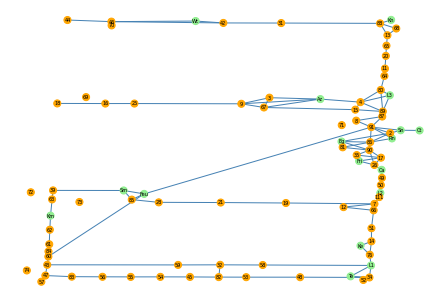

In [5]:
#draw maps
#G = draw_graph("labs_map.yaml")
G = draw_graph("aaf_map.yaml")
#G = draw_graph_tsc("tsc_map.yaml")

# 2) Try to fit lognormal (AAF)
- Not bad

In [234]:
count = df_aaf["edge_id"].value_counts()
count.to_excel("WP_pairs_aaf.xlsx")
count.head()

WayPoint35_Frisoer       602
WayPoint86_WayPoint90    600
Frisoer_WayPoint35       589
WayPoint86_WayPoint91    574
WayPoint90_WayPoint35    568
Name: edge_id, dtype: int64

MAP mean: 1.76     MAP var: 0.01
Time for calculation: 0.2721836566925049 secs


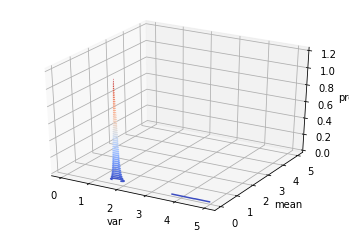

In [237]:
# 1) Select data of interest
origin = "Frisoer"
target = "WayPoint35"
edge = origin + "_" + target
subset = select_data_edge(df_aaf, edge)
#independent variable to plot over
t_op = subset["operation_time"] - subset["time_to_waypoint"] 
#t_op = subset["operation_time"] 
#2) fit model

#use offset and take log of data
offset= np.min(t_op) - 0.01
t_log = np.log(t_op - offset)

#n_terms = 1 if you want just the initial estimates
n_terms = len(t_log)    
t_obs = t_log[0:n_terms]

#set parameters
mu_0 = 1
beta = 0.1
a = 1
b = 1

#Bayesian MAP estimate of mean & variance of Gaussian distribution
tic = time.time()
mean_test, var_test, posterior, mean_map, var_map = Normal_Gamma_bayes(t_obs, mu_0, beta, a, b)
toc = time.time()
print("MAP mean:", mean_map, "    MAP var:", var_map)
print("Time for calculation:", toc-tic, "secs")

Time taken (kde): 1.5497384071350098 secs


Text(0.5, 1.0, 'Frisoer_WayPoint35')

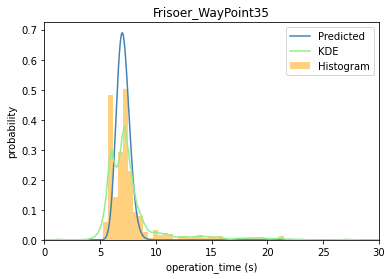

In [238]:
#Plot against actual data

precision = 2
t_start= 10**(-precision)
t_stop = ( (np.max(t_op)) //5)*5 + 5    #round up to nearest 5 secs
t_step = 10**(-precision)
t_test = np.arange(t_start,t_stop,t_step)

#Duration distribution using MAP parameters from Bayesian method
p_bayes = Lognormal(t_test-offset,mean_map,var_map)

#plot prediction
plt.plot(t_test,p_bayes, color = "steelblue", alpha = 1)

#plot kde
p_kde = kde(t_test, t_op, kernel = "exponential", max_bandwidth = 5, bandwidth_precision = 0.1, cv = 10)
plt.plot(t_test, p_kde, color = "lightgreen", alpha = 1)

#plot actual
plt.hist(t_op, density = True, bins = 200, color = "orange", alpha = 0.5);

plt.legend(["Predicted", "KDE", "Histogram"])
plt.xlabel("operation_time (s)")
plt.ylabel("probability")
plt.xlim([0,30])
plt.title(edge)

In [11]:
ks_lib = sp.stats.kstest(t_op, 
                         lambda k: sp.stats.lognorm.cdf(
                             k, s = np.sqrt(var_map), loc = offset, scale = np.exp(mean_map)
                         ))
print(ks_lib)

KstestResult(statistic=0.20288994584973194, pvalue=9.841174019490991e-22)


# 3) Try all distributions (AAF)

In [4]:
#create an array of the distributions we would like to test
#Did this by removing the distributions from "possible" that could not be fitted

#dist_cont = ["norm", "lognorm", "gamma", "invgauss", "beta", "betaprime", "burr", "cauchy", "chi2", "levy"]

dist_cont = ['alpha', 'anglit', 'arcsine', 'argus', 'beta', 'betaprime', 
             'bradford', 'burr', 'burr12', 'cauchy', 'chi', 'chi2', 'cosine', 
             'crystalball', 'dgamma', 'dweibull', 'expon', 'exponnorm', 'exponpow', 
             'exponweib', 'f', 'fatiguelife', 'fisk', 'foldcauchy', 'foldnorm', 
             'frechet_l', 'frechet_r', 'gamma', 'genextreme', 'gengamma', 'genhalflogistic', 'geninvgauss',
             'genlogistic', 'gennorm', 'genpareto', 'gilbrat', 'gompertz', 'gumbel_l', 
             'gumbel_r', 'halfcauchy', 'halfgennorm', 'halflogistic', 'halfnorm', 'hypsecant', 
             'invgamma', 'invgauss', 'johnsonsb', 'johnsonsu', 'kappa3', 'kappa4',
             'laplace', 'levy', 'levy_l', 'loggamma', 'logistic', 'loglaplace', 'lognorm', 
             'loguniform', 'lomax', 'maxwell', 'mielke', 'moyal', 'nakagami',
             'ncx2', 'norm', 'norminvgauss', 'pareto', 'pearson3', 'powerlaw', 
             'powerlognorm', 'powernorm', 'rayleigh', 'rice', 'semicircular', 'skewnorm', 't', 
             'trapz', 'triang', 'truncexpon', 'truncnorm','uniform', 'vonmises', 
             'vonmises_line', 'wald', 'weibull_max', 'weibull_min']

n_dist = len(dist_cont)

print(n_dist)
print(dist_cont)

86
['alpha', 'anglit', 'arcsine', 'argus', 'beta', 'betaprime', 'bradford', 'burr', 'burr12', 'cauchy', 'chi', 'chi2', 'cosine', 'crystalball', 'dgamma', 'dweibull', 'expon', 'exponnorm', 'exponpow', 'exponweib', 'f', 'fatiguelife', 'fisk', 'foldcauchy', 'foldnorm', 'frechet_l', 'frechet_r', 'gamma', 'genextreme', 'gengamma', 'genhalflogistic', 'geninvgauss', 'genlogistic', 'gennorm', 'genpareto', 'gilbrat', 'gompertz', 'gumbel_l', 'gumbel_r', 'halfcauchy', 'halfgennorm', 'halflogistic', 'halfnorm', 'hypsecant', 'invgamma', 'invgauss', 'johnsonsb', 'johnsonsu', 'kappa3', 'kappa4', 'laplace', 'levy', 'levy_l', 'loggamma', 'logistic', 'loglaplace', 'lognorm', 'loguniform', 'lomax', 'maxwell', 'mielke', 'moyal', 'nakagami', 'ncx2', 'norm', 'norminvgauss', 'pareto', 'pearson3', 'powerlaw', 'powerlognorm', 'powernorm', 'rayleigh', 'rice', 'semicircular', 'skewnorm', 't', 'trapz', 'triang', 'truncexpon', 'truncnorm', 'uniform', 'vonmises', 'vonmises_line', 'wald', 'weibull_max', 'weibull_min

In [5]:
errors = gof_multiple_edge(df_aaf, model_list = dist_cont, n_edge = 25)
print("done")

C:\Users\pyliu\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
C:\Users\pyliu\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:496: RuntimeWarning: divide by zero encountered in true_divide
  return 1.0/np.pi/np.sqrt(x*(1-x))
C:\Users\pyliu\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\pyliu\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\pyliu\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:781: RuntimeWarning: divide by zero encountered in true_divide
  a/(b-1.0),
C:\Users\pyliu\anaconda3\lib\site-packages\scipy\stats\_continuous_dist

0 WayPoint35_Frisoer 9.025106430053711 secs


C:\Users\pyliu\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:8434: RuntimeWarning: divide by zero encountered in double_scalars
  A = chi**3 / (_norm_pdf_C * _argus_phi(chi))


1 WayPoint86_WayPoint90 15.873070240020752 secs


C:\Users\pyliu\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:6411: RuntimeWarning: overflow encountered in power
  pow(_norm_cdf(-np.log(x)/s), c*1.0-1.0))


2 Frisoer_WayPoint35 23.117996215820312 secs
3 WayPoint86_WayPoint91 31.369643926620483 secs


C:\Users\pyliu\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1726: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(self._pdf, _a, x, args=args)[0]


4 WayPoint90_WayPoint35 38.990647077560425 secs
5 WayPoint87_WayPoint89 46.00799918174744 secs
6 WayPoint89_WayPoint87 53.22258234024048 secs


C:\Users\pyliu\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:1605: RuntimeWarning: divide by zero encountered in log
  return exparg + np.log(0.5 * invK * sc.erfc(-(x - invK) / np.sqrt(2)))


7 WayPoint35_WayPoint90 60.96509671211243 secs
8 WayPoint90_WayPoint81 68.86930465698242 secs
9 WayPoint91_WayPoint87 76.21753525733948 secs
10 WayPoint81_WayPoint86 84.27146244049072 secs
11 WayPoint87_WayPoint91 92.01043105125427 secs
12 WayPoint4_WayPoint89 100.41293168067932 secs
13 WayPoint26_Cafeteria 107.46457481384277 secs


C:\Users\pyliu\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1722: RuntimeWarning: invalid value encountered in log
  return log(self._pdf(x, *args))
C:\Users\pyliu\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:5269: RuntimeWarning: overflow encountered in power
  return x**k / (1.0+x**s)**(k*1.0/s)
C:\Users\pyliu\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:5269: RuntimeWarning: invalid value encountered in true_divide
  return x**k / (1.0+x**s)**(k*1.0/s)
C:\Users\pyliu\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


14 Cafeteria_WayPoint26 115.28594827651978 secs
15 WayPoint91_WayPoint86 122.53324460983276 secs
16 Frisoer_WayPoint26 130.08493041992188 secs
17 WayPoint26_Frisoer 136.9426667690277 secs
18 Lift2_WayPoint111 143.844660282135 secs
19 WayPoint50_Lift2 151.0312855243683 secs
20 WayPoint111_Lift2 158.18769574165344 secs
21 Lift2_WayPoint50 165.12458205223083 secs


C:\Users\pyliu\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


22 WayPoint50_WayPoint49 172.1022810935974 secs
23 WayPoint49_WayPoint50 178.94799518585205 secs
24 WayPoint49_Cafeteria 186.5841052532196 secs
Time taken: 186.58610939979553 secs
done


In [6]:
ks_errors = errors.sort_values("KS statistic", ascending = True).reset_index(drop = True)
ks_errors.head(20)

,Model,KS statistic,KS p-value
0,johnsonsu,0.130245,3.166599e-03
1,foldcauchy,0.182406,7.934254e-06
2,cauchy,0.193182,1.146909e-07
3,t,0.200758,4.081442e-06
4,fisk,0.214037,1.313237e-06
5,gennorm,0.219305,1.894505e-09
6,alpha,0.227148,1.695167e-06
7,burr,0.227267,2.832790e-07
8,burr12,0.230888,3.509847e-05
9,loglaplace,0.241201,4.034903e-05


# 4) Try johnsonsu distribution

(-1.9518715144463146, 0.7977334648465717, 5.6954204543535205, 0.22175489192413167)


Text(0.5, 1.0, 'Frisoer_WayPoint35')

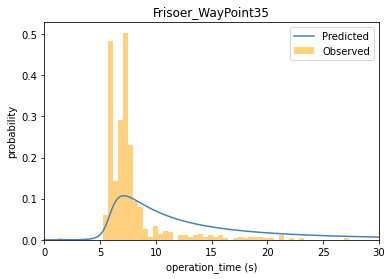

In [25]:
# 1) Select data of interest
origin = "Frisoer"
target = "WayPoint35"
edge = origin + "_" + target
subset = select_data_edge(df_aaf, edge)
#independent variable to plot over
t_op = subset["operation_time"] -  subset["time_to_waypoint"]

#fit model
d = "johnsonsu"
model = getattr(sp.stats, d)
params = model.fit(t_op)
print(params)

#Plot against actual data

precision = 2
t_start= 10**(-precision)
t_stop = ( (np.max(t_op)) //5)*5 + 5    #round up to nearest 5 secs
t_step = 10**(-precision)
t_test = np.arange(t_start,t_stop,t_step)

p_sp = model.pdf(t_test, params[0], params[1], params[2])

#plot prediction
plt.plot(t_test,p_sp, color = "steelblue", alpha = 1)

#plot actual
plt.hist(t_op, density = True, bins = 200, color = "orange", alpha = 0.5)

plt.legend(["Predicted", "Observed"])
plt.xlabel("operation_time (s)")
plt.ylabel("probability")
plt.xlim([0,30])
plt.title(edge)
    

# 5) Cluster edges (AAF)

## 5ai) According to KS metric (2sample)
- considers operation time (not operation_time - time_to_waypoint)

In [17]:
ks_matrix, ks_edges = distances_ks(df_aaf, metric = "operation_time")

Time taken: 70.65347599983215 secs


Optimum no. of clusters: 5
Min CH index: 23.488659331520616


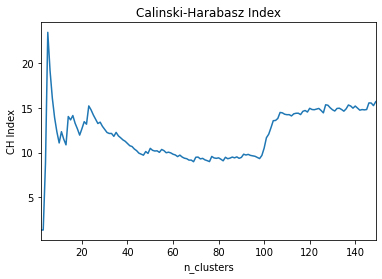

In [22]:
n_clusters, s_list = optimum_clusters(ks_matrix, max_clusters = 150, method = "ch")

In [23]:
clustering = AgglomerativeClustering(n_clusters=5, affinity='precomputed', linkage = 'average')
labels = clustering.fit_predict( ks_matrix )
print(labels)
ks_clusters = pd.DataFrame(index = np.arange(len(ks_edges)),columns = ["edge_id", "cluster_id"])
ks_clusters["edge_id"] = ks_edges
ks_clusters["cluster_id"] = labels
print(np.max(labels) + 1, "clusters")

[0 0 0 1 0 4 4 4 0 0 0 0 0 0 0 1 0 0 0 4 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0
 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 1 4 1 0 1 1 1 1
 1 0 1 0 1 0 1 0 1 0 0 4 4 1 4 4 4 1 0 0 0 0 0 1 1 0 0 1 1 1 0 1 1 1 0 0 1
 1 0 4 1 4 4 4 4 4 1 1 4 1 1 0 0 1 0 1 1 1 1 1 1 4 1 0 0 1 0 0 1 0 4 0 0 1
 0 0 1 1 0 0 1 0 0 0 0 1 4 0 0 1 0 0 1 4 1 0 2 1 0 0 0 0 1 0 0 0 0 1 1 1 0
 3 0]
5 clusters


no. of edges: 220
CLuster 0 has colour code: r
CLuster 1 has colour code: g
CLuster 2 has colour code: b
CLuster 3 has colour code: c
CLuster 4 has colour code: m
Edges without enough data are black


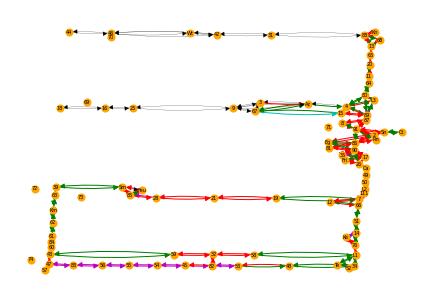

In [24]:
G = draw_clusters("aaf_map.yaml", ks_clusters)
plt.savefig("clusters_ks_aaf.png", dpi = 1000)

## 5aii) According to KS metric (2sample)
- considers operation_time - time_to_waypoint (not operation_time)

In [8]:
ks_matrix, ks_edges = distances_ks(df_aaf, metric = "difference")

Time taken: 76.41063356399536 secs


Optimum no. of clusters: 5
Max silhouette coeff: 0.15198723419088483


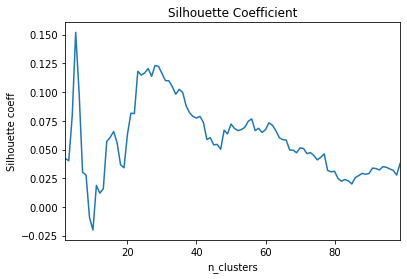

In [240]:
n_clusters, s_list = optimum_clusters(ks_matrix, max_clusters = 100, method = "ss")

In [243]:
clustering = AgglomerativeClustering(n_clusters=17, affinity='precomputed', linkage = 'average')
labels = clustering.fit_predict( ks_matrix )
print(labels)
ks_clusters = pd.DataFrame(index = np.arange(len(ks_edges)),columns = ["edge_id", "cluster_id"])
ks_clusters["edge_id"] = ks_edges
ks_clusters["cluster_id"] = labels
print(np.max(labels) + 1, "clusters")

[ 1  6  6  0  6 14 14  4  6  1  1  1  1  1  6  0  6  6  6  4  6  6  6  6
  1  6 10 10  1  6  1  0  2  6  1  6  6  3  6  1  6  1  0  1  1 10  6  1
  0  1  1  6  1  6  1  1  1  0  6  6  1  0 10  6  6  2 10  4 10  6  2  0
  0  0  0 10  1  0  0  6  3  6  0  3  1  0  4 14  4  4  4  0  1  6  6  1
  0  6  0  1  6  0 10  0  0  2  0  6  1  0  6  0  1  4  0 14  4 14 14  0
  4  0  0  0  4  6  1  0  3  0  0  2  0  2  0 14  0  3  2  3  1  3  0  1
  6  6  1  0 14  1 10  6  6  2  0  6  3  6  1 10  1  3  0  6  0  1  6  4
 11 14  0  1  0  3 10  1  6  6  5 16 13 15  5 12  8  9  7]
17 clusters


no. of edges: 220
CLuster 0 has colour code: r
CLuster 1 has colour code: g
CLuster 2 has colour code: b
CLuster 3 has colour code: c
CLuster 4 has colour code: m
CLuster 5 has colour code: yellow
CLuster 6 has colour code: orange
CLuster 7 has colour code: purple
CLuster 8 has colour code: lime
CLuster 9 has colour code: cyan
CLuster 10 has colour code: darkgray
CLuster 11 has colour code: pink
CLuster 12 has colour code: brown
CLuster 13 has colour code: olive
CLuster 14 has colour code: gold
CLuster 15 has colour code: teal
CLuster 16 has colour code: maroon
Edges without enough data are black


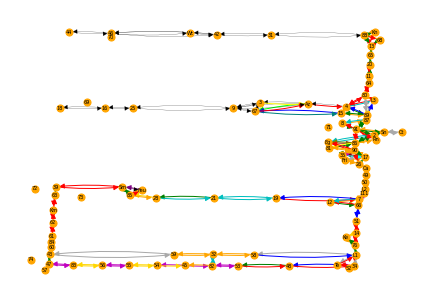

In [244]:
G = draw_clusters("aaf_map.yaml", ks_clusters)
plt.savefig("clusters_ksdiff_aaf20.png", dpi = 1000)

## 5bi) According to edge length
- only for the same edges that have data as in the KS matrix

In [21]:
#Create matrix of edge_length distances
context = get_context("aaf_map.yaml")
#length_matrix, length_edges = distances_length(context)
length_matrix, length_edges = distances_length_subset(context,ks_edges)

Time taken: 0.7377338409423828 secs
Time taken:  1.4691228866577148 secs


Optimum no. of clusters: 96
Max silhouette coeff: 0.973257006956089


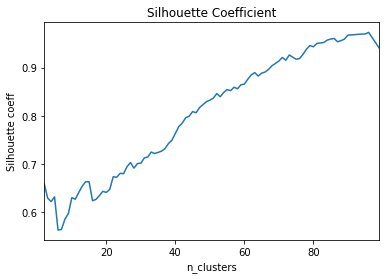

In [22]:
n_clusters, s_list = optimum_clusters(length_matrix, max_clusters = 100, method = "ss")

In [23]:
#for edge_length difference
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=5, affinity='precomputed', linkage = 'average')
labels = clustering.fit_predict( length_matrix )
print(labels)
length_clusters = pd.DataFrame(index = np.arange(len(length_edges)),columns = ["edge_id", "cluster_id"])
length_clusters["edge_id"] = length_edges
length_clusters["cluster_id"] = labels
print(np.max(labels)+1, "clusters")

[0 2 2 2 2 0 2 0 2 2 2 2 2 2 2 2 0 1 3 0 0 0 2 2 2 2 1 2 0 0 2 2 2 2 0 2 0
 2 2 2 2 2 0 2 0 0 0 2 2 1 2 2 2 2 2 1 0 2 0 0 2 0 0 0 0 2 2 2 0 0 2 0 2 2
 0 0 2 0 2 2 2 2 0 2 2 0 0 0 2 4 2 2 0 2 2 0 0 2 2 2 2 0 1 0 2 2 2 2 2 2 2
 2 2 3 2 4 2 0 2 0 0 2 1 2 0 0 0 2 2 1 1 0 2 2 2 1 2 2 0 0 2 2 2 0 2 0 3 2
 2 2 2 0 2 2 2 2 2 2 2 2 0 2 2 0 2 2 0 2 2 0 1 2 0 2 3 2 2 0 2 0 2 2 2 2 0
 0 0]
5 clusters


no. of edges: 220
CLuster 0 has colour code: r
CLuster 1 has colour code: g
CLuster 2 has colour code: b
CLuster 3 has colour code: c
CLuster 4 has colour code: m
Edges without enough data are black


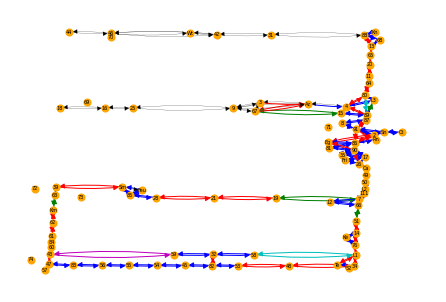

In [24]:
G = draw_clusters("aaf_map.yaml", length_clusters)
plt.savefig("clusters_length_aaf_subset.png", dpi = 1000)

## 5bii) According to edge length
- for all edges

In [14]:
#Create matrix of edge_length distances
context = get_context("aaf_map.yaml")
length_matrix, length_edges = distances_length(context)

Time taken: 0.7282571792602539 secs
Time taken:  1.3124401569366455 secs


Optimum no. of clusters: 110
Max silhouette coeff: 0.9999935425683794


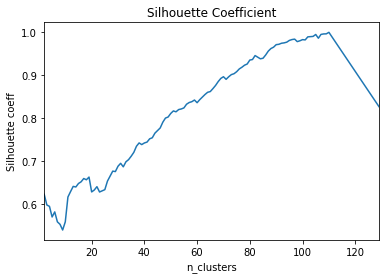

In [17]:
n_clusters, s_list = optimum_clusters(length_matrix, max_clusters = 130, method = "ss")

In [18]:
#for edge_length difference
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=16, affinity='precomputed', linkage = 'average')
labels = clustering.fit_predict( length_matrix )
print(labels)
length_clusters = pd.DataFrame(index = np.arange(len(length_edges)),columns = ["edge_id", "cluster_id"])
length_clusters["edge_id"] = length_edges
length_clusters["cluster_id"] = labels
print(np.max(labels)+1, "clusters")

[11  2 14  1  9 14  5  4  9  1  9  9  9  9  9  9  6  5  2 11  3  4  1  4
 14  5  6  9 11  9  4  9  2  6  5  5 10  4  5  9 11  4 10  5 10 10 10  1
 10  4  2  2  9 10  0  9  6  9 10  9  9 14  6  0  4  5  4  1 10  4  1  4
  4  3  9  9 10  9 12  4  9 14  1  1  1 15 14 14  4  2 13  5  4  9  9  9
  6  2  6 10 14  1  4  1  9  7  1 14  8  6  9  9 11  6  7  1  9  9  2  1
 10 14 10 14  2  0 13  1  9  9  9  9  9  9  9  9 14  3 14  8 14  9 12 10
  2 12  6 11 10  2  1  1 10 10  0  1  0  9  2 10  9 10  0 10 10  2  1  6
 10 10  2  9  4  7 10  9  9  9  4  9  9 10  9  9  9  6  9 10  1  9 14 12
 10  9  1  9  5 15  4 11  9  1  9  7 14  3  9 11  9 14  1  9 12 14 10 10
 10 12  1  4]
16 clusters


no. of edges: 220
CLuster 0 has colour code: r
CLuster 1 has colour code: g
CLuster 2 has colour code: b
CLuster 3 has colour code: c
CLuster 4 has colour code: m
CLuster 5 has colour code: yellow
CLuster 6 has colour code: orange
CLuster 7 has colour code: purple
CLuster 8 has colour code: lime
CLuster 9 has colour code: cyan
CLuster 10 has colour code: darkgray
CLuster 11 has colour code: pink
CLuster 12 has colour code: brown
CLuster 13 has colour code: olive
CLuster 14 has colour code: gold
CLuster 15 has colour code: teal
Edges without enough data are black


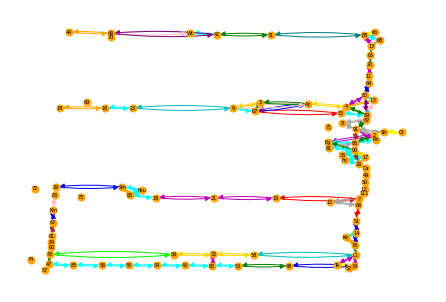

In [20]:
G = draw_clusters("aaf_map.yaml", length_clusters)
plt.savefig("clusters_length_aaf.png", dpi = 1000)

## 5c) According to connections
- only consider connections at the target node 
- If we consider both origin & target, we get 27 clusters

In [41]:
#Create matrix of connections_diff distances
context = get_context("aaf_map.yaml")
connections_matrix, connections_edges = distances_connections2(context)

Time taken: 0.7466840744018555 secs
Time taken:  1.2082438468933105 secs


Optimum no. of clusters: 6
Max silhouette coeff: 1.0


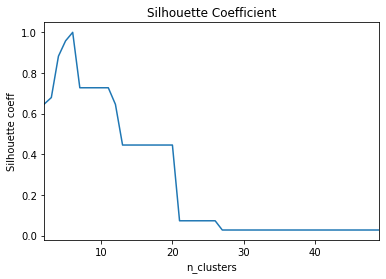

In [42]:
n_clusters, s_list = optimum_clusters(connections_matrix, max_clusters = 50, method = "ss")

In [43]:
#for connections difference
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=n_clusters[np.argmax(s_list)], affinity='precomputed', linkage = 'average')
labels = clustering.fit_predict( connections_matrix )
print(labels)
connections_clusters = pd.DataFrame(index = np.arange(len(connections_edges)),columns = ["edge_id", "cluster_id"])
connections_clusters["edge_id"] = connections_edges
connections_clusters["cluster_id"] = labels
print(n_clusters[np.argmax(s_list)], "clusters")

[1 1 4 0 1 3 0 1 2 2 0 0 1 0 1 0 0 1 3 3 3 3 0 1 3 3 4 1 4 2 2 3 3 0 5 1 2
 1 1 0 0 3 3 3 1 1 0 3 3 1 3 0 3 4 1 4 5 3 1 0 0 2 3 1 3 0 0 2 2 3 3 3 3 1
 3 3 1 0 2 3 0 1 1 1 0 1 3 3 0 3 5 3 1 1 0 2 3 0 0 0 1 4 1 3 3 0 0 3 3 0 3
 0 3 5 0 0 5 3 1 3 3 3 3 3 0 0 1 3 0 3 3 3 3 3 3 0 0 1 0 0 0 3 3 3 3 3 3 3
 3 1 0 3 3 1 3 0 0 1 1 0 1 3 3 0 3 0 1 3 0 2 3 0 4 4 2 2 3 3 0 3 0 3 3 3 3
 0 3 3 1 0 2 2 3 4 2 3 5 3 0 0 0 4 0 1 0 3 1 1 0 1 0 3 1 2 3 0 1 2 0 3]
6 clusters


no. of edges: 220
CLuster 0 has colour code: r
CLuster 1 has colour code: g
CLuster 2 has colour code: b
CLuster 3 has colour code: c
CLuster 4 has colour code: m
CLuster 5 has colour code: yellow
Edges without enough data are black


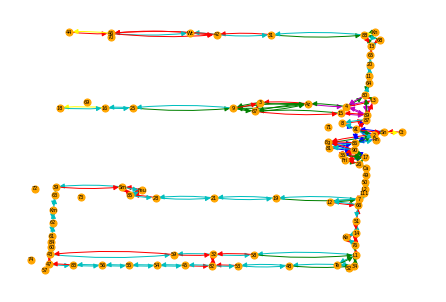

In [44]:
G = draw_clusters("aaf_map.yaml", connections_clusters)
plt.savefig("clusters_connections_aaf.png", dpi = 1000)

## 5di) According to angle of turning
- max angle of turning

In [5]:
angle_matrix, angle_edges = distances_angle_max("aaf_map.yaml")

Time taken: 0.7356564998626709 secs
Time taken: 0.5964052677154541 secs
Time taken: 0.669788122177124 secs
Time taken:  5.820306062698364 secs


Optimum no. of clusters: 2
Max silhouette coeff: 0.7576408231527906


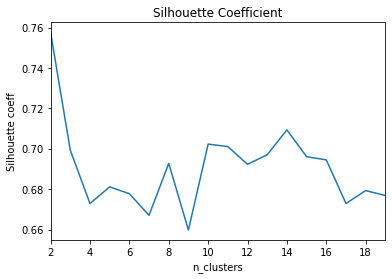

In [38]:
n_clusters, s_list = optimum_clusters(angle_matrix, max_clusters = 20, method = "ss")

In [41]:
#for connections difference
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=8, affinity='precomputed', linkage = 'average')
labels = clustering.fit_predict( angle_matrix )
print(labels)
angle_clusters = pd.DataFrame(index = np.arange(len(angle_edges)),columns = ["edge_id", "cluster_id"])
angle_clusters["edge_id"] = angle_edges
angle_clusters["cluster_id"] = labels
print(np.max(labels) + 1, "clusters")

[1 3 2 2 1 1 0 1 2 1 5 0 0 0 3 0 1 0 1 1 1 5 1 0 1 1 0 0 1 1 1 3 5 2 7 1 0
 0 5 1 1 1 1 1 1 2 2 1 2 0 1 1 0 1 0 3 7 1 0 5 5 1 1 5 1 2 3 0 1 1 1 1 0 1
 1 1 0 0 1 1 2 2 5 1 1 2 1 1 5 1 7 5 1 3 0 0 1 0 2 3 1 0 1 1 0 1 1 1 1 1 1
 1 0 7 1 1 7 1 5 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 5 1 5 1 1 1 1 1 1 5 1
 1 1 1 1 4 1 1 5 1 0 2 1 2 4 1 1 1 1 1 0 2 1 1 0 1 1 1 2 1 1 5 1 3 1 1 3 0
 3 3 6 1 4 1 1 3 1 1 2 7 1 1 0 1 0 1 1 2 1 0 0 0 0 3 6 1 1 3 0 2 1 1 3]
8 clusters


no. of edges: 220
CLuster 0 has colour code: r
CLuster 1 has colour code: g
CLuster 2 has colour code: b
CLuster 3 has colour code: c
CLuster 4 has colour code: m
CLuster 5 has colour code: yellow
CLuster 6 has colour code: orange
CLuster 7 has colour code: purple
Edges without enough data are black


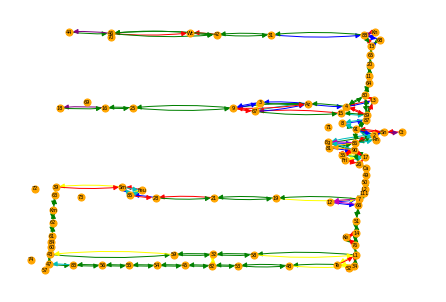

In [42]:
G = draw_clusters("aaf_map.yaml", angle_clusters)
plt.savefig("clusters_angle_max.png", dpi = 1000)

## 5e) According to multi-sample CRPS

In [8]:
# Select data of interest
wp1 = "WayPoint50"
wp2 = "WayPoint49"
edge1 = wp1 + "_" + wp2
subset1 = select_data_edge(df_aaf, edge1)
#independent variable to plot over
t_op1 = subset1["operation_time"]-subset1["time_to_waypoint"]

wp1 = "WayPoint49"
wp2 = "WayPoint50"
edge2 = wp1 + "_" + wp2
subset2 = select_data_edge(df_aaf, edge2)
#independent variable to plot over
t_op2 = subset2["operation_time"]-subset2["time_to_waypoint"]
print("done")

done


0.37493734335839674 KstestResult(statistic=0.4557416267942584, pvalue=0.0) 0.10353052566102972


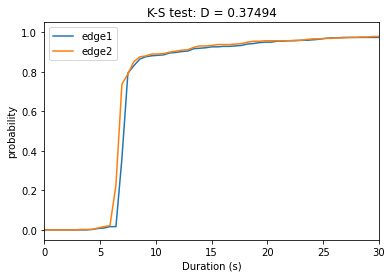

In [9]:
my_ks = error_ks_2samples(t_op1, t_op2, plot_graph = True)
lib_ks = sp.stats.ks_2samp(t_op1, t_op2)
square = error_square_2samples(t_op1, t_op2, plot_graph = False)
plt.xlim([0,30])
print(my_ks, lib_ks, square)

## 5ei) According to Square distance
- considers operation_time (not operation_time - time_to_waypoint)

In [32]:
square_matrix, square_edges = distances_square(df_aaf, metric = "difference")

0 edges: 0.03242015838623047 secs
10 edges: 3.347708225250244 secs
20 edges: 6.648141145706177 secs
30 edges: 9.595771789550781 secs
40 edges: 12.299129247665405 secs
50 edges: 15.03859543800354 secs
60 edges: 17.725704193115234 secs
70 edges: 20.426085233688354 secs
80 edges: 22.995136737823486 secs
90 edges: 25.504485845565796 secs
100 edges: 27.973725080490112 secs
110 edges: 30.47874402999878 secs
120 edges: 33.12525272369385 secs
130 edges: 35.51096749305725 secs
140 edges: 37.96334671974182 secs
150 edges: 40.35463547706604 secs
160 edges: 42.7245135307312 secs
170 edges: 45.124908685684204 secs
180 edges: 47.557172536849976 secs
Time taken: 49.24489998817444 secs


Optimum no. of clusters: 2
Max silhouette coeff: 0.8915407845547959


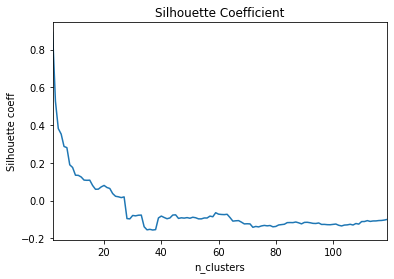

In [34]:
n_clusters, s_list = optimum_clusters(square_matrix, max_clusters = 120, method = "ss")

In [42]:
clustering = AgglomerativeClustering(n_clusters=5, affinity='precomputed', linkage = 'average')
labels = clustering.fit_predict( square_matrix )
print(labels)
square_clusters = pd.DataFrame(index = np.arange(len(square_edges)),columns = ["edge_id", "cluster_id"])
square_clusters["edge_id"] = square_edges
square_clusters["cluster_id"] = labels
print(np.max(labels) + 1, "clusters")

[1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 4 2 0 0 0 1 1 0 0 0 0
 0 0 0 0 0 1 0 0 0 2 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 2 0 0 1 2 0 2 0 1 1 1 1
 1 0 2 0 1 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 1 2 1 0 1 1 1 0 0 1
 1 0 0 1 0 0 0 0 0 1 1 0 1 1 0 0 1 1 1 2 1 1 1 1 0 1 1 0 1 0 0 0 0 0 0 0 1
 0 0 4 2 0 1 1 0 0 0 0 2 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 2 0 0 0 0 3 3 1 0
 3 0]
5 clusters


no. of edges: 220
CLuster 0 has colour code: r
CLuster 1 has colour code: g
CLuster 2 has colour code: b
CLuster 3 has colour code: c
CLuster 4 has colour code: m
Edges without enough data are black


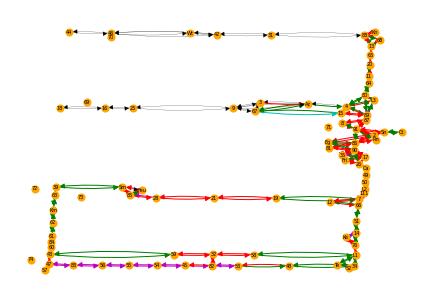

In [43]:
G = draw_clusters("aaf_map.yaml", ks_clusters)
plt.savefig("clusters_square_aaf.png", dpi = 1000)

## 5eii) According to Square distance
- considers operation_time - time_to_waypoint (not operation_time)

In [245]:
square_matrix, square_edges = distances_square(df_aaf, metric = "difference")

0 edges: 0.1168525218963623 secs
10 edges: 3.4139394760131836 secs
20 edges: 6.341507434844971 secs
30 edges: 9.20352816581726 secs
40 edges: 11.846969366073608 secs
50 edges: 14.327178955078125 secs
60 edges: 16.785287380218506 secs
70 edges: 19.25206708908081 secs
80 edges: 21.693050861358643 secs
90 edges: 24.24722194671631 secs
100 edges: 26.654316902160645 secs
110 edges: 29.073750972747803 secs
120 edges: 31.61160182952881 secs
130 edges: 34.12192130088806 secs
140 edges: 36.72837281227112 secs
150 edges: 39.24127459526062 secs
160 edges: 41.65045976638794 secs
170 edges: 44.07628560066223 secs
180 edges: 46.452467918395996 secs
Time taken: 48.13148474693298 secs


Optimum no. of clusters: 2
Max silhouette coeff: 0.9228737865729286


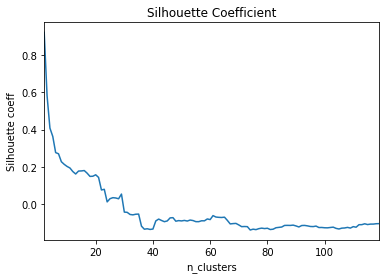

In [249]:
n_clusters, s_list = optimum_clusters(square_matrix, max_clusters = 120, method = "ss")

In [38]:
clustering = AgglomerativeClustering(n_clusters=5, affinity='precomputed', linkage = 'average')
labels = clustering.fit_predict( square_matrix )
print(labels)
square_clusters = pd.DataFrame(index = np.arange(len(square_edges)),columns = ["edge_id", "cluster_id"])
square_clusters["edge_id"] = square_edges
square_clusters["cluster_id"] = labels
print(np.max(labels) + 1, "clusters")

[1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 1 0 1 1 1 1 0 1 1 1 0 1 0 1 1 4 1 1 0 2 1 2 1 4 0 1 0
 0 1 0 0 0 1 0 1 0 0 1 1 1 0 1 1 1 0 1 1 1 0 1 0 0 1 1 0 4 0 1 0 0 0 1 1 0
 0 1 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 4 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 1 1
 1 1 2 4 1 0 0 1 0 1 1 4 1 0 1 0 1 1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 1 0 0 0 1
 3 1]
5 clusters


no. of edges: 220
CLuster 0 has colour code: r
CLuster 1 has colour code: g
CLuster 2 has colour code: b
CLuster 3 has colour code: c
CLuster 4 has colour code: m
Edges without enough data are black


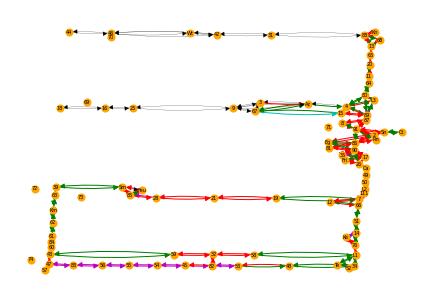

In [39]:
G = draw_clusters("aaf_map.yaml", ks_clusters)
plt.savefig("clusters_square_aaf.png", dpi = 1000)

## 5fi) According to CVM (operation_time)

In [5]:
cvm_matrix, cvm_edges = distances_cvm(df_aaf, metric = "operation_time")

0 edges: 0.0738060474395752 secs
10 edges: 2.8837597370147705 secs
20 edges: 5.595929384231567 secs
30 edges: 8.358175992965698 secs
40 edges: 10.79245138168335 secs
50 edges: 12.938973665237427 secs
60 edges: 15.051493883132935 secs
70 edges: 17.102339506149292 secs
80 edges: 19.405840396881104 secs
90 edges: 21.502005577087402 secs
100 edges: 23.51530647277832 secs
110 edges: 25.615479230880737 secs
120 edges: 27.771860361099243 secs
130 edges: 29.90119171142578 secs
140 edges: 32.09429311752319 secs
150 edges: 34.32833170890808 secs
160 edges: 89.28217625617981 secs
170 edges: 94.51389789581299 secs
180 edges: 97.17601466178894 secs
Time taken: 97.18100094795227 secs


Optimum no. of clusters: 2
Max silhouette coeff: 0.5934282750786181


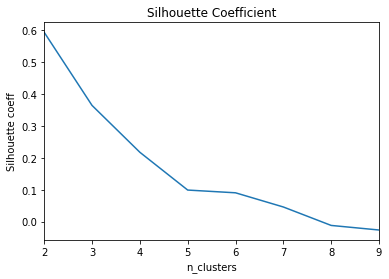

In [12]:
n_clusters, s_list = optimum_clusters(cvm_matrix, max_clusters = 10, method = "ss")

## 5fii) According to CVM (difference)

In [28]:
cvm_matrix, cvm_edges = distances_cvm(df_aaf, metric = "difference")

0 edges: 0.030424833297729492 secs
10 edges: 2.471153736114502 secs
20 edges: 4.852405071258545 secs
30 edges: 7.210828065872192 secs
40 edges: 9.43803858757019 secs
50 edges: 11.63386607170105 secs
60 edges: 13.995455741882324 secs
70 edges: 16.22899866104126 secs
80 edges: 18.352731943130493 secs
90 edges: 20.466192960739136 secs
100 edges: 22.74461007118225 secs
110 edges: 24.81983709335327 secs
120 edges: 26.90226125717163 secs
130 edges: 28.96202325820923 secs
140 edges: 31.021705389022827 secs
150 edges: 33.073222398757935 secs
160 edges: 79.39007496833801 secs
170 edges: 84.19482254981995 secs
180 edges: 86.661696434021 secs
Time taken: 86.66667795181274 secs


Optimum no. of clusters: 2
Max silhouette coeff: 0.5823592953987506


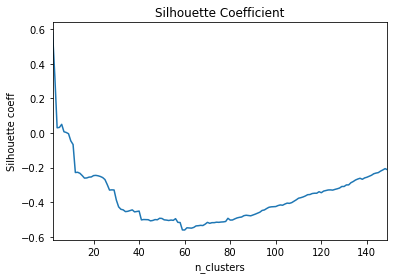

In [31]:
n_clusters, s_list = optimum_clusters(cvm_matrix, max_clusters = 150, method = "ss")

# 6) Classification
- Logistic regression
- output is whether 2 edges are in the same cluster
- input is the factors (edge length, target connections, max angle of turning)
- ground truth is clustering formed by ks/square clustering

## 6a) Get data into correct format
- From Seciton 5, we have ks_clusters/square_clusters and the corresponding edge ids
- Then augment this dataframe with edge_id, edge_length, target_connections, max_angle

In [5]:
ks_matrix, ks_edges = distances_ks(df_aaf, metric = "operation_time")


0 edges: 0.03291034698486328 secs
10 edges: 8.950063467025757 secs
20 edges: 16.08021068572998 secs
30 edges: 22.714897632598877 secs
40 edges: 28.20434808731079 secs
50 edges: 32.029112577438354 secs
60 edges: 35.59831118583679 secs
70 edges: 39.10122561454773 secs
80 edges: 42.298925161361694 secs
90 edges: 45.37254571914673 secs
100 edges: 48.395893812179565 secs
110 edges: 51.344153881073 secs
120 edges: 54.28789734840393 secs
130 edges: 57.2083957195282 secs
140 edges: 60.072049617767334 secs
150 edges: 62.89051055908203 secs
160 edges: 65.71165633201599 secs
170 edges: 68.49979257583618 secs
180 edges: 71.33546710014343 secs
Time taken: 73.26058053970337 secs


Optimum no. of clusters: 5
Max silhouette coeff: 0.15198723419088483


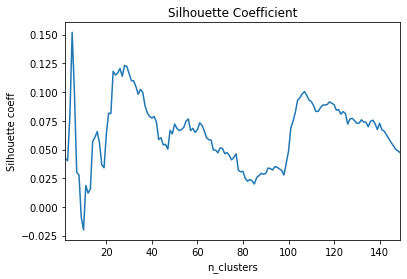

In [6]:
n_clusters, s_list = optimum_clusters(ks_matrix, max_clusters = 150, method = "ss")

[0 0 0 1 0 4 4 4 0 0 0 0 0 0 0 1 0 0 0 4 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0
 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 1 4 1 0 1 1 1 1
 1 1 0 1 1 0 0 0 1 0 0 1 4 4 4 4 4 1 0 0 0 0 1 0 1 0 0 1 1 1 1 1 1 0 0 1 0
 1 0 4 1 4 4 4 4 1 4 1 1 1 4 0 0 1 0 1 1 1 1 1 1 4 1 0 1 0 0 0 1 0 0 0 0 1
 4 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 1 0 0 4 2 4 1 0 1 0 1 0 0 0 0 1 1 3 0 0 1
 0 0]
5 clusters
no. of edges: 220
CLuster 0 has colour code: r
CLuster 1 has colour code: g
CLuster 2 has colour code: b
CLuster 3 has colour code: c
CLuster 4 has colour code: m
Edges without enough data are black


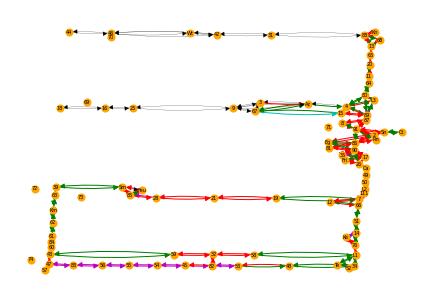

In [7]:
clustering = AgglomerativeClustering(n_clusters=5, affinity='precomputed', linkage = 'average')
labels = clustering.fit_predict( ks_matrix )
print(labels)
ks_clusters = pd.DataFrame(index = np.arange(len(ks_edges)),columns = ["edge_id", "cluster_id"])
ks_clusters["edge_id"] = ks_edges
ks_clusters["cluster_id"] = labels
print(np.max(labels) + 1, "clusters")
G = draw_clusters("aaf_map.yaml", ks_clusters)

In [8]:
length = get_length("aaf_map.yaml")
connections = get_connections("aaf_map.yaml")
angle_max = get_angle_max("aaf_map.yaml")

Time taken (get_length): 0.6368722915649414 secs
Time taken (get_connections): 0.6328485012054443 secs
Time taken (get_angle_max): 1.8511607646942139 secs


### Start from here to choose a new cluster

In [621]:
df_class = pd.DataFrame(columns = ["edge_id", "cluster_id", "edge_length", "n_connections_origin", "n_connections_target", "max_angle"])
df_class["edge_id"] = ks_clusters["edge_id"]
df_class["cluster_id"] = ks_clusters["cluster_id"]
for i in range(len(ks_clusters)):
    df_class["edge_length"][i] = length[df_class["edge_id"][i]]
    df_class["n_connections_origin"][i] = connections[df_class["edge_id"][i]][0]
    df_class["n_connections_target"][i] = connections[df_class["edge_id"][i]][1]
    df_class["max_angle"][i] = angle_max[df_class["edge_id"][i]]
df_class.head(2)

,edge_id,cluster_id,edge_length,n_connections_origin,n_connections_target,max_angle
0,WayPoint35_Frisoer,0,2.84521,3,3,2.57488
1,WayPoint86_WayPoint90,0,3.82142,6,6,3.05479


In [614]:
#only include this for section 6. Skip for section 7
desired_class = 2
for i in range(len(df_class)):
    if df_class["cluster_id"][i] == desired_class:
        df_class["cluster_id"][i] = 1
    else:
        df_class["cluster_id"][i] = 0
df_class.head(2)
        

,edge_id,cluster_id,edge_length,n_connections_origin,n_connections_target,max_angle
0,WayPoint35_Frisoer,0,2.84521,3,3,2.57488
1,WayPoint86_WayPoint90,0,3.82142,6,6,3.05479


## 6b) Logistic Regression

In [533]:
#helper functions
def find_sigmoid(z):
  return 1/(1+np.exp(-z))

def find_loss(y,y_hat):
  return np.sum(-y*np.log(y_hat)-(1-y)*np.log(1-y_hat),axis=1)

def find_h(X,w,w0):
  return w@X + w0

In [557]:
df_class_random = df_class.sample(frac = 1).reset_index(drop = True)

n_train = 100
#class labels
y = np.array(df_class_random["cluster_id"])
y = y[np.newaxis,0:n_train]
y_test = np.array(df_class_random["cluster_id"])
y_test = y_test[np.newaxis,n_train:]
print(y.shape)

#attributes
X = np.array(df_class_random[["edge_length", "n_connections_origin", "n_connections_target", "max_angle"]][0:n_train])
X = X.transpose()
X_test = np.array(df_class_random[["edge_length", "n_connections_origin", "n_connections_target", "max_angle"]][n_train:])
X_test = X_test.transpose()
print(X.shape)

(1, 100)
(4, 100)


final weight vector: w0 then w
[[0.79146942]] [[-0.48280499370282853 0.055860884674247546 0.14268901040256743
  0.3991411117429769]]


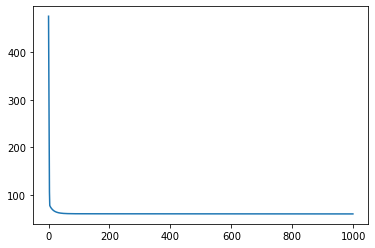

In [558]:
#initialise weight vector
w = np.random.randn(1,X.shape[0])
w0 = 0

# number of iterations & learning rate
n_iter = 1000
lr = 0.001
losses = []

for i in range(n_iter):
    h = find_h(X,w,w0)
    h = h.astype(float)
    y_hat = find_sigmoid(h)

    #grad is (y_hat-y)*(x_j)

    grad_w = (y_hat-y) @ X.T
    grad_w0 = np.sum((y_hat-y), axis=1, keepdims=True)



    w = w-lr*grad_w
    w0= w0-lr*grad_w0

    #keep loss for plotting vs iter
    losses.append(find_loss(y,y_hat))

print("final weight vector: w0 then w")
print(w0,w)
plt.plot(losses)


In [559]:
#test
h = find_h(X_test,w,w0)
h = h.astype(float)
y_hat = find_sigmoid(h)
y_pred = np.array( y_hat>0.5 )
n_errors = np.sum(np.abs(y_pred - y_test))
n_total = y_test.size
print("Incorrect:", n_errors)
print("Total:", n_total)
print("Proportion correct:", (n_total-n_errors)/n_total)

Incorrect: 27
Total: 87
Proportion correct: 0.6896551724137931


In [560]:
y_pred.reshape(1,-1)
y_test.reshape(1,-1)
y_test = y_test == 1
print(classification_report(y_test[0], y_pred[0], zero_division=0))

              precision    recall  f1-score   support

       False       0.85      0.49      0.62        45
        True       0.62      0.90      0.74        42

    accuracy                           0.69        87
   macro avg       0.73      0.70      0.68        87
weighted avg       0.74      0.69      0.68        87



# 7) Classification 2
- Logistic regression
- output is whether 2 edges are in the same cluster
- input is the DIFFERENCE in factors (edge length, target connections, max angle of turning)
- ground truth is clustering formed by ks/square clustering

## 7a) Adapt data into correct format

In [1087]:
df_class = pd.DataFrame(columns = ["edge_id", "cluster_id", "edge_length", "n_connections_origin", "n_connections_target", "max_angle"])
df_class["edge_id"] = ks_clusters["edge_id"]
df_class["cluster_id"] = ks_clusters["cluster_id"]
for i in range(len(ks_clusters)):
    df_class["edge_length"][i] = length[df_class["edge_id"][i]]
    df_class["n_connections_origin"][i] = connections[df_class["edge_id"][i]][0]
    df_class["n_connections_target"][i] = connections[df_class["edge_id"][i]][1]
    df_class["max_angle"][i] = angle_max[df_class["edge_id"][i]]
df_class.head(2)

,edge_id,cluster_id,edge_length,n_connections_origin,n_connections_target,max_angle
0,WayPoint35_Frisoer,0,2.84521,3,3,2.57488
1,WayPoint86_WayPoint90,0,3.82142,6,6,3.05479


In [1088]:
max_n= int(np.ceil((len(df_class) * (len(df_class)-1)) / 2))
df_class_diff = pd.DataFrame(index = np.arange(max_n), columns = ["edge1", "edge2", "same_cluster","edge_length_diff", "connections_diff", "max_angle_diff"])
ind = 0
for i in range(len(df_class)-1):
    for j in range(i+1, len(df_class)):
        df_class_diff["edge1"][ind] = df_class["edge_id"][i]
        df_class_diff["edge2"][ind] = df_class["edge_id"][j]
        if df_class["cluster_id"][i] == df_class["cluster_id"][j]:
            df_class_diff["same_cluster"][ind] = 1
        else:
            df_class_diff["same_cluster"][ind] = 0
        df_class_diff["edge_length_diff"][ind] = np.abs( df_class["edge_length"][i] - df_class["edge_length"][j])
        df_class_diff["connections_diff"][ind] = np.abs( df_class["n_connections_target"][i] - df_class["n_connections_target"][j])
        df_class_diff["max_angle_diff"][ind] = np.abs( df_class["max_angle"][i] - df_class["max_angle"][j])
        ind += 1
df_class_diff.tail()

,edge1,edge2,same_cluster,edge_length_diff,connections_diff,max_angle_diff
17386,WayPoint3_Ambulanz,WayPoint17_WayPoint35,0,2.1697,1,1.2879
17387,WayPoint3_Ambulanz,Feuerloescher_Seminarraum,1,2.23617,1,0.476826
17388,Eingang_WayPoint86,WayPoint17_WayPoint35,0,0.0982852,3,0.687242
17389,Eingang_WayPoint86,Feuerloescher_Seminarraum,1,0.164753,3,0.123834
17390,WayPoint17_WayPoint35,Feuerloescher_Seminarraum,0,0.0664677,0,0.811077


## 7b) Logistic Regression (my implementation)

In [1086]:
df_0 = df_class_diff[df_class_diff["same_cluster"]==0]
df_1 = df_class_diff[df_class_diff["same_cluster"]==1]
if len(df_0) < len(df_1):
    df_class_random = pd.concat(df_0, df_1[:len(df_0)])
df_class_random.head()

,edge1,edge2,same_cluster,edge_length_diff,origin_connections_diff,target_connections_diff,total_connections_diff,max_angle_diff,sum_angle_diff
0,WayPoint32_WayPoint59,Kapelle_WayPoint76,1,0.506385,1,1,0,0.156845,0.0632232
1,WayPoint50_WayPoint49,WayPoint47_WayPoint43,1,1.67539,1,1,2,0.031262,1.63009
2,Station_WayPoint2,Lift1_Teekueche,0,3.85505,1,2,1,1.39995,5.48918
3,WayPoint90_WayPoint81,WayPoint91_WayPoint86,0,4.35725,0,4,4,1.85652,6.90733
4,Feuerloescher_WayPoint85,WayPoint76_Kapelle,1,1.42079,1,1,0,0.839241,0.274023


In [1037]:
df_0 = df_class_diff[df_class_diff["same_cluster"]==0]
df_1 = df_class_diff[df_class_diff["same_cluster"]==1]
if len(df_0) < len(df_1):
    df_class_random = pd.concat([df_0, df_1[:len(df_0)]])
else:
    df_class_random = pd.concat([df_1, df_0[:len(df_1)]])
df_class_random = df_class_random.sample(frac = 1).reset_index(drop = True)

n_train = 1000
#class labels
y = np.array(df_class_random["same_cluster"])
y = y[np.newaxis,0:n_train]
y_test = np.array(df_class_random["same_cluster"])
y_test = y_test[np.newaxis,n_train:]
print(y.shape)

#attributes
X = np.array(df_class_random[["edge_length_diff", "connections_diff","max_angle_diff"]][0:n_train])
X = X.transpose()
X_test = np.array(df_class_random[["edge_length_diff", "connections_diff","max_angle_diff"]][n_train:])
X_test = X_test.transpose()
print(X.shape)

(1, 1000)
(3, 1000)


final weight vector: w0 then w
[[0.711272723623201]] [[-0.39779772467865687 -0.018046479626050282 0.14441113472116401]]


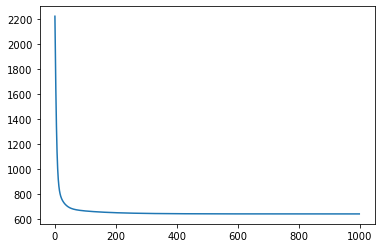

In [1038]:
#train
w0, w = logistic_regression(X, y, n_iter = 1000, lr = 0.0001, plot_graph = True)

In [1039]:
#test
h = find_h(X_test,w,w0)
h = h.astype(float)
y_hat = find_sigmoid(h)
y_pred = np.array( y_hat>0.5 )
n_errors = np.sum(np.abs(y_pred - y_test))
n_total = y_test.size
print("Incorrect:", n_errors)
print("Total:", n_total)
print("Proportion correct:", (n_total-n_errors)/n_total)

Incorrect: 4900
Total: 13352
Proportion correct: 0.6330137807070102


F1 score is a relative measure, but it is better than accuracy in highly-skewed datasets

In [1040]:
tp = 0
tn = 0
fp = 0
fn = 0
for i in range(len(y_pred[0])):
    if y_pred[0][i] == True and y_test[0][i] == 1:
        tp += 1
    elif y_pred[0][i] == False and y_test[0][i] == 0:
        tn += 1
    elif y_pred[0][i] == True and y_test[0][i] == 0:
        fp += 1
    elif y_pred[0][i] == False and y_test[0][i] == 1:
        fn += 1
    else:
        print("Error")
precision = tp/(tp + fp)
recall = tp/(tp + fn)
f1 = (2*precision*recall)/(precision+recall)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

Precision: 0.6211273372458032
Recall: 0.6817977528089888
F1: 0.6500499928581631


In [1041]:
y_pred.reshape(1,-1)
y_test.reshape(1,-1)
y_test = y_test == 1
print(classification_report(y_test[0], y_pred[0], zero_division=0))

              precision    recall  f1-score   support

       False       0.65      0.58      0.61      6677
        True       0.62      0.68      0.65      6675

    accuracy                           0.63     13352
   macro avg       0.63      0.63      0.63     13352
weighted avg       0.63      0.63      0.63     13352



## 7c) Sklearn logistic regression

In [1094]:
df_0 = df_class_diff[df_class_diff["same_cluster"]==0]
df_1 = df_class_diff[df_class_diff["same_cluster"]==1]
if len(df_0) < len(df_1):
    df_class_random = pd.concat([df_0, df_1[:len(df_0)]])
else:
    df_class_random = pd.concat([df_1, df_0[:len(df_1)]])
df_class_random = df_class_random.sample(frac = 1).reset_index(drop = True)

n_train = 1000
#class labels
y = np.array(df_class_random["same_cluster"])
y = list(y[0:n_train])
y_test = np.array(df_class_random["same_cluster"])
y_test = list(y_test[n_train:])
#y.shape


#attributes
X = np.array(df_class_random[["edge_length_diff", "connections_diff","max_angle_diff"]][0:n_train])
X_test = np.array(df_class_random[["edge_length_diff", "connections_diff","max_angle_diff"]][n_train:])
print(X.shape)

(1000, 3)


In [1095]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0).fit(X, y)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.68      0.53      0.59      6696
           1       0.61      0.75      0.67      6656

    accuracy                           0.64     13352
   macro avg       0.65      0.64      0.63     13352
weighted avg       0.65      0.64      0.63     13352



In [1091]:
#cross validation
cv = 100
y = list(df_class_random["same_cluster"])
X = np.array(df_class_random[["edge_length_diff", "connections_diff","max_angle_diff"]])
lr = LogisticRegression(random_state=0)
cv_results = cross_validate(lr, X, y, cv=100)
print("Mean:", cv_results["test_score"].mean())
print("Std:", cv_results["test_score"].std())

Mean: 0.6382187257187257
Std: 0.04365146835451446


In [654]:
y_pred = lr.predict(X_test)
print("Wrong:", np.sum(np.abs(y_pred-y_test)))
print("Total:",len(y_test))
print("Proportion correct:", (len(y_test) - np.sum(np.abs(y_pred-y_test))) / len(y_test))


Wrong: 4776
Total: 12391
Proportion correct: 0.6145589540795738


In [655]:
tp = 0
tn = 0
fp = 0
fn = 0
for i in range(len(y_test)):
    if y_pred[i] == True and y_test[i] == 1:
        tp += 1
    elif y_pred[i] == False and y_test[i] == 0:
        tn += 1
    elif y_pred[i] == True and y_test[i] == 0:
        fp += 1
    elif y_pred[i] == False and y_test[i] == 1:
        fn += 1
    else:
        print("Error")
print(tp,tn,fp,fn)
precision = tp/(tp + fp)
recall = tp/(tp + fn)
f1 = (2*precision*recall)/(precision+recall)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)

2126 5489 1750 3026
Precision: 0.5485036119711042
Recall: 0.4126552795031056
F1: 0.47097917589720867


# 8) Logistic regression - more input variables
- Origin connections
- Total connections
- Sum of angles of turning


## 8a) Process data

In [183]:
length = get_length("aaf_map.yaml")
connections = get_connections("aaf_map.yaml")
angle_max = get_angle_max("aaf_map.yaml")
angle_sum = get_angle_sum("aaf_map.yaml")

Time taken (get_length): 0.720470666885376 secs
Time taken (get_connections): 0.6856973171234131 secs
Time taken (get_angle_max): 2.9973840713500977 secs
Time taken (get_angle_sum): 1.7957863807678223 secs


In [184]:
df_class = pd.DataFrame(columns = ["edge_id", "cluster_id", "edge_length", "n_connections_origin", "n_connections_target","n_connections_total", "max_angle","sum_angle"])
df_class["edge_id"] = ks_clusters["edge_id"]
df_class["cluster_id"] = ks_clusters["cluster_id"]
for i in range(len(ks_clusters)):
    df_class["edge_length"][i] = length[df_class["edge_id"][i]]
    df_class["n_connections_origin"][i] = connections[df_class["edge_id"][i]][0]
    df_class["n_connections_target"][i] = connections[df_class["edge_id"][i]][1]
    df_class["n_connections_total"][i] = connections[df_class["edge_id"][i]][0] + connections[df_class["edge_id"][i]][1]
    df_class["max_angle"][i] = angle_max[df_class["edge_id"][i]]
    df_class["sum_angle"][i] = angle_sum[df_class["edge_id"][i]]
df_class.head(2)

,edge_id,cluster_id,edge_length,n_connections_origin,n_connections_target,n_connections_total,max_angle,sum_angle
0,WayPoint35_Frisoer,0,2.84521,3,3,6,2.57488,3.55565
1,WayPoint86_WayPoint90,0,3.82142,6,6,12,3.05479,10.2523


In [185]:
max_n= int(np.ceil((len(df_class) * (len(df_class)-1)) / 2))
df_class_diff = pd.DataFrame(index = np.arange(max_n), columns = ["edge1", "edge2", "same_cluster",
                                                                  "edge_length_diff", "origin_connections_diff", 
                                                                  "target_connections_diff", "total_connections_diff", 
                                                                  "max_angle_diff", "sum_angle_diff"])
ind = 0
for i in range(len(df_class)-1):
    for j in range(i+1, len(df_class)):
        df_class_diff["edge1"][ind] = df_class["edge_id"][i]
        df_class_diff["edge2"][ind] = df_class["edge_id"][j]
        if df_class["cluster_id"][i] == df_class["cluster_id"][j]:
            df_class_diff["same_cluster"][ind] = 1
        else:
            df_class_diff["same_cluster"][ind] = 0
        df_class_diff["edge_length_diff"][ind] = np.abs( df_class["edge_length"][i] - df_class["edge_length"][j])
        df_class_diff["origin_connections_diff"][ind] = np.abs( df_class["n_connections_origin"][i] - df_class["n_connections_origin"][j])
        df_class_diff["target_connections_diff"][ind] = np.abs( df_class["n_connections_target"][i] - df_class["n_connections_target"][j])
        df_class_diff["total_connections_diff"][ind] = np.abs( df_class["n_connections_total"][i] - df_class["n_connections_total"][j])
        df_class_diff["max_angle_diff"][ind] = np.abs( df_class["max_angle"][i] - df_class["max_angle"][j])
        df_class_diff["sum_angle_diff"][ind] = np.abs( df_class["sum_angle"][i] - df_class["sum_angle"][j])
        
        ind += 1
df_class_diff.tail()

,edge1,edge2,same_cluster,edge_length_diff,origin_connections_diff,target_connections_diff,total_connections_diff,max_angle_diff,sum_angle_diff
17386,Eingang_WayPoint86,WayPoint35_WayPoint17,1,0.0982852,0,2,2,0.400611,4.32881
17387,Eingang_WayPoint86,Feuerloescher_Seminarraum,1,0.164753,1,3,4,0.123834,5.06465
17388,Ambulanz_WayPoint67,WayPoint35_WayPoint17,0,3.99261,1,0,1,0.123514,0.485461
17389,Ambulanz_WayPoint67,Feuerloescher_Seminarraum,0,4.05907,2,1,3,0.64796,0.250378
17390,WayPoint35_WayPoint17,Feuerloescher_Seminarraum,1,0.0664677,1,1,2,0.524446,0.735838


## 8b) My logistic regression

In [1099]:
df_0 = df_class_diff[df_class_diff["same_cluster"]==0]
df_1 = df_class_diff[df_class_diff["same_cluster"]==1]
if len(df_0) < len(df_1):
    df_class_random = pd.concat([df_0, df_1[:len(df_0)]])
else:
    df_class_random = pd.concat([df_1, df_0[:len(df_1)]])
df_class_random = df_class_random.sample(frac = 1).reset_index(drop = True)

n_train = 1000
#class labels
y = np.array(df_class_random["same_cluster"])
y = y[np.newaxis,0:n_train]
y_test = np.array(df_class_random["same_cluster"])
y_test = y_test[np.newaxis,n_train:]
print(y.shape)

#attributes
X = np.array(df_class_random[["edge_length_diff", "origin_connections_diff", 
                              "target_connections_diff", "total_connections_diff", 
                              "max_angle_diff", "sum_angle_diff"]][0:n_train])
X = X.transpose()
X_test = np.array(df_class_random[["edge_length_diff", "origin_connections_diff", 
                              "target_connections_diff", "total_connections_diff", 
                              "max_angle_diff", "sum_angle_diff"]][n_train:])
X_test = X_test.transpose()
print(X.shape)

(1, 1000)
(6, 1000)


final weight vector: w0 then w
[[0.9221402261008552]] [[-0.3802170736817561 0.04220658585719928 0.059786468500903356
  -0.02735685100543647 -0.05446591887835266 -0.07342826048203743]]


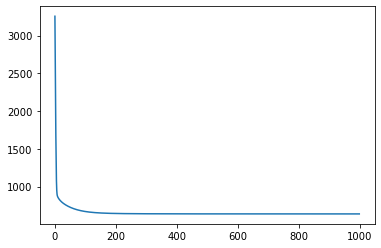

In [1100]:
#train
w0, w = logistic_regression(X, y, n_iter = 1000, lr = 0.0001, plot_graph = True)

In [1101]:
h = find_h(X_test,w,w0)
h = h.astype(float)
y_hat = find_sigmoid(h)
y_pred = np.array( y_hat>0.5 )
y_pred.reshape(1,-1)

y_test = np.array(y_test)
y_test.reshape(1,-1)
y_test = y_test == 1
print(classification_report(y_test[0], y_pred[0], zero_division=0))

              precision    recall  f1-score   support

       False       0.66      0.56      0.61      6673
        True       0.62      0.71      0.66      6679

    accuracy                           0.64     13352
   macro avg       0.64      0.64      0.63     13352
weighted avg       0.64      0.64      0.63     13352



## 8c) Sklearn logistic regression

In [1102]:
df_0 = df_class_diff[df_class_diff["same_cluster"]==0]
df_1 = df_class_diff[df_class_diff["same_cluster"]==1]
if len(df_0) < len(df_1):
    df_class_random = pd.concat([df_0, df_1[:len(df_0)]])
else:
    df_class_random = pd.concat([df_1, df_0[:len(df_1)]])
df_class_random = df_class_random.sample(frac = 1).reset_index(drop = True)

n_train = 1000
#class labels
y = np.array(df_class_random["same_cluster"])
y = list(y[0:n_train])
y_test = np.array(df_class_random["same_cluster"])
y_test = list(y_test[n_train:])
#y.shape


#attributes
X = np.array(df_class_random[["edge_length_diff", "origin_connections_diff", 
                              "target_connections_diff", "total_connections_diff", 
                              "max_angle_diff", "sum_angle_diff"]][0:n_train])
X_test = np.array(df_class_random[["edge_length_diff", "origin_connections_diff", 
                                   "target_connections_diff", "total_connections_diff", 
                                   "max_angle_diff", "sum_angle_diff"]][n_train:])
print(X.shape)

(1000, 6)


In [1103]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0).fit(X, y)
y_pred = lr.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.65      0.58      0.61      6673
           1       0.62      0.68      0.65      6679

    accuracy                           0.63     13352
   macro avg       0.63      0.63      0.63     13352
weighted avg       0.63      0.63      0.63     13352



In [1106]:
#cross validation
cv = 100
y = list(df_class_random["same_cluster"])
X = np.array(df_class_random[["edge_length_diff", "origin_connections_diff", 
                              "target_connections_diff", "total_connections_diff", 
                              "max_angle_diff", "sum_angle_diff"]])
lr = LogisticRegression(random_state=0)
cv_results = cross_validate(lr, X, y, cv=cv)
print("Mean:", cv_results["test_score"].mean())
print("Std:", cv_results["test_score"].std())

Mean: 0.6383343045843046
Std: 0.03627954315734542


## 8d) Sklearn Logistic Regression for increasing amounts of training data

# 9) Alternatives to logistic regression
- NN
- SVM
- Random forest
- KNN

## 9a) Neural Network - single hidden layer

In [1107]:
df_0 = df_class_diff[df_class_diff["same_cluster"]==0]
df_1 = df_class_diff[df_class_diff["same_cluster"]==1]
if len(df_0) < len(df_1):
    df_class_random = pd.concat([df_0, df_1[:len(df_0)]])
else:
    df_class_random = pd.concat([df_1, df_0[:len(df_1)]])
df_class_random = df_class_random.sample(frac = 1).reset_index(drop = True)

n_train = 1000
#class labels
y = np.array(df_class_random["same_cluster"])
y = y[np.newaxis,0:n_train]
y_test = np.array(df_class_random["same_cluster"])
y_test = y_test[np.newaxis,n_train:]
print(y.shape)

#attributes
X = np.array(df_class_random[["edge_length_diff", "origin_connections_diff", 
                              "target_connections_diff", "total_connections_diff", 
                              "max_angle_diff", "sum_angle_diff"]][0:n_train])
X = X.transpose()
X_test = np.array(df_class_random[["edge_length_diff", "origin_connections_diff", 
                              "target_connections_diff", "total_connections_diff", 
                              "max_angle_diff", "sum_angle_diff"]][n_train:])
X_test = X_test.transpose()
print(X.shape)

(1, 1000)
(6, 1000)


In [1108]:
#helper functions
def find_sigmoid(z):
  return 1/(1+np.exp(-z))

def find_loss(y,y_hat):
  return np.sum(-y*np.log(y_hat)-(1-y)*np.log(1-y_hat),axis=1)

def find_z(X,w,b):
  return w@X + b

def forward_pass(X,W,b):
  Z = find_z(X,W,b)
  A = find_sigmoid(Z)
  return Z,A

final weight vector: W1 then W2
[[0.3865877226785193 0.029854022637030492 -1.1375986060712509
  1.2829610736523875 0.32107841749379706 0.3565392354559993]
 [2.0858512765260886 -0.529137662295489 -0.7811603590955533
  -0.07430921588260482 -0.7649121718097127 0.2155161872564102]
 [-1.2784964793132214 0.38192216843349447 -1.6140174476698386
  0.027391154629338478 -1.0008378446528616 -0.6693669578623299]
 [-0.18571324499706388 0.1546495394936854 -0.030776787680747604
  1.4308013413513043 0.8993060830331359 0.01191000466556182]
 [0.5152852177103995 1.4097163391696512 0.831004659684155
  -0.32139692591521307 -1.0405216025631878 2.335555593059029]
 [-0.3115567271098338 1.0814314737766333 1.8699061859361992
  -1.962890046687299 -1.0568487484167643 -1.2565332013608685]
 [2.2631404709904546 0.0314571747721054 1.5702978811313324
  1.061304438400159 0.27765724191584495 0.9001336165753991]
 [1.0757299169907228 -1.450185504655666 1.1506099357858688
  -0.5269060164897779 -2.024572451224701 0.82391790

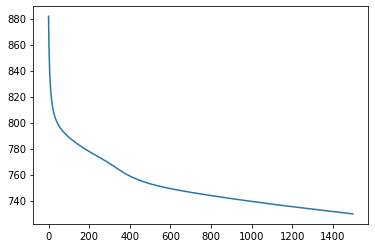

In [1109]:
#how many nodes in our hidden layer?
num_layer = 10

"""what are the sizes of our matrices? y.shape = W2*W1*X.shape since sigmoid does not change shape (element-wise operation)
#X is (X.shape[0],X.shape[1]) since X has 2 features
#y is (1,X.shape[1])
#W1 is (num_layer,X.shape[0])
#b1 is same size as W1*X = (num_layer,X.shape[1])
#W2 is (1,num_layer)
#b2 is same size as W2*Z1 = W2*sigmoid(W1*X) = (1,X.shape[1])"""

#initialise W1, b1, W2, b2
W1 = np.random.randn(num_layer,X.shape[0])
b1 = np.random.randn(num_layer,X.shape[1])
#b1 = np.random.randn(num_layer,1)

W2 = np.random.randn(1,num_layer)
b2 = np.random.randn(1,X.shape[1])
#b2 = np.random.randn(1,1)
"""
print(W1.shape)
print(b1.shape)
print(W2.shape)
print(b2.shape)
"""

# number of iterations & learning rate
n_iter = 1500
lr = 1
losses = []

for i in range(n_iter):
    #forward pass
    #X ==> Z1 ==> sigmoid ==> A1 ==> Z2 ==> sigmoid ==> A2 = y_hat
    Z1 = find_z(X,W1,b1)
    Z1 = Z1.astype(float)
    A1 = find_sigmoid(Z1)
    Z2 = find_z(A1,W2,b2)
    Z2 = Z2.astype(float)
    A2 = find_sigmoid(Z2)

    #backward pass
    dZ2 = A2 - y            
    dW2 = (1/X.shape[1])* dZ2 @ A1.T
    db2 = (1/X.shape[1])*np.sum(dZ2,axis=1,keepdims=True)

    dZ1 = W2.T@dZ2 * A1 * (1 - A1)
    dW1 = (1/X.shape[1])* dZ1 @ X.T
    db1 = (1/X.shape[1])*np.sum(dZ1,axis=1,keepdims=True)

    #find_loss
    losses.append(find_loss(y,A2))

    #update weights
    W1 = W1 - lr*dW1
    b1= b1 - lr*db1
    W2 = W2 - lr*dW2
    b2= b2 - lr*db2

print("final weight vector: W1 then W2")
print(W1,W2)
plt.plot(losses)

In [1110]:
#predict
h = W2@W1@X_test
h = h.astype(float)
y_hat = find_sigmoid(h)

y_pred = np.array( y_hat>0.5 )
y_pred.reshape(1,-1)

y_test = np.array(y_test)
y_test.reshape(1,-1)
y_test = y_test == 1
print(classification_report(y_test[0], y_pred[0], zero_division=0))


              precision    recall  f1-score   support

       False       0.65      0.43      0.52      6699
        True       0.57      0.76      0.65      6653

    accuracy                           0.60     13352
   macro avg       0.61      0.60      0.58     13352
weighted avg       0.61      0.60      0.58     13352



## 9b) SGD optimise - one layer

In [1071]:
df_0 = df_class_diff[df_class_diff["same_cluster"]==0]
df_1 = df_class_diff[df_class_diff["same_cluster"]==1]
if len(df_0) < len(df_1):
    df_class_random = pd.concat([df_0, df_1[:len(df_0)]])
else:
    df_class_random = pd.concat([df_1, df_0[:len(df_1)]])
df_class_random = df_class_random.sample(frac = 1).reset_index(drop = True)

n_train = 1000
#class labels
y = np.array(df_class_random["same_cluster"])
y = y[np.newaxis,0:n_train]

y_test = np.array(df_class_random["same_cluster"])
y_test = y_test[n_train:]

print(y.shape)

#attributes
X = np.array(df_class_random[["edge_length_diff", "origin_connections_diff", 
                              "target_connections_diff", "total_connections_diff", 
                              "max_angle_diff", "sum_angle_diff"]][0:n_train])
X = X.transpose()

X_test = np.array(df_class_random[["edge_length_diff", "origin_connections_diff", 
                              "target_connections_diff", "total_connections_diff", 
                              "max_angle_diff", "sum_angle_diff"]][n_train:])
X_test = X_test.transpose()

print(X.shape)
X = X.astype(float)
y = y.astype(float)
X_test = X_test.astype(float)
y_test = y_test.astype(float)

(1, 1000)
(6, 1000)


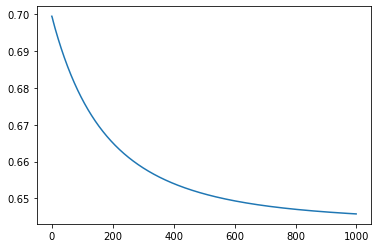

In [1072]:
# Fully connected neural network with one hidden layer
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, out_size):
        super(Net, self).__init__()
        # nn.linear has convention x@W vs our previous convention of W@z
        self.layer1 = nn.Linear(input_size, hidden_size)     #W1 to connect to x, matrix multiplication of input size, output has hidden_size                           
        self.layer2 = nn.Linear(hidden_size, out_size)       #W2 to connect to y
    
    def forward(self, x):           #forward pass
        x = torch.sigmoid(self.layer1(x))     #A1 = sigmoid(Z1 = W1*X)
        x = torch.sigmoid(self.layer2(x))     #A2 = sigmoid(Z2 = W2*A1)
        return x



ni = 6        #input dim
nh = 100      #number of hidden units
no = 1        #output dim
lr = 0.01     #learning rate
losses = []   #keep track of loss
n_iter = 1000

#create neural network instance
model = Net(ni,nh,no)

#define an optimiser (stochastic Gradient Descent)
criterion = nn.BCELoss()                                                  #pick loss function (binary cross entropy)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = 0.5)    #use SCG optimiser

#transpose matrices
X_tensor = torch.from_numpy(X.T).type(torch.float)
y_tensor = torch.from_numpy(y.T).type(torch.float)

for i in range(n_iter):
    optimizer.zero_grad()           # 1) reset grad since pytorch accumulates grad
    y_hat = model(X_tensor)                # 2) forward pass - calling model(X) automatically calls model.forward(X)
    loss = criterion(y_hat, y_tensor)      # 3) keep track of losses
    losses.append(loss)             
    loss.backward()                 # 4) backward pass
    optimizer.step()                # 5) update weights

plt.figure()
plt.plot(losses)

In [1073]:
#predict
X_test_tensor = torch.from_numpy(X_test.T).type(torch.float)
y_hat = model(X_test_tensor)
y_hat = y_hat.detach().numpy()
y_pred = np.array( y_hat>0.5 )
y_pred.reshape(1,-1)

y_test = np.array(y_test)
print(classification_report(y_test, y_pred, zero_division=0))


              precision    recall  f1-score   support

         0.0       0.63      0.59      0.61      6661
         1.0       0.62      0.65      0.63      6691

    accuracy                           0.62     13352
   macro avg       0.62      0.62      0.62     13352
weighted avg       0.62      0.62      0.62     13352



## 9c) More hidden layers
- worse performance (overfit?)

In [1074]:
# Fully connected neural network with one hidden layer
class Net1(nn.Module):
    def __init__(self, input_size, hidden_size, out_size):
        super(Net1, self).__init__()
        # nn.linear has convention x@W vs our previous convention of W@z
        self.layer1 = nn.Linear(input_size, hidden_size[0])     #W1 to connect to x, matrix multiplication of input size, output has hidden_size                           
        self.layer2 = nn.Linear(hidden_size[0], out_size)       #W2 to connect to y
    
    def forward(self, x):                     #forward pass
        x = torch.sigmoid(self.layer1(x))     #A1 = sigmoid(Z1 = W1*X)
        x = torch.sigmoid(self.layer2(x))     #A2 = sigmoid(Z2 = W2*A1)
        return x

In [1075]:
# Fully connected neural network with two hidden layers
class Net2(nn.Module):
    def __init__(self, input_size, hidden_size, out_size):
        "hidden_size is an array containing the size of layers 1 to n"
        super(Net2, self).__init__()
        # nn.linear has convention x@W vs our previous convention of W@z
        self.layer1 = nn.Linear(input_size, hidden_size[0])     #W1 to connect to x, matrix multiplication of input size, output has hidden_size                           
        self.layer2 = nn.Linear(hidden_size[0], hidden_size[1])       
        self.layer3 = nn.Linear(hidden_size[1], out_size)

    
    def forward(self, x):                     #forward pass
        x = torch.sigmoid(self.layer1(x))     #A1 = sigmoid(Z1 = W1*X)
        x = torch.sigmoid(self.layer2(x))     #A2 = sigmoid(Z2 = W2*A1)
        x = torch.sigmoid(self.layer3(x))     #A3 = sigmoid(Z3 = W3*A2)
        return x

In [1076]:
# Fully connected neural network with 3 hidden layers
class Net3(nn.Module):
    def __init__(self, input_size, hidden_size, out_size):
        "hidden_size is an array containing the size of layers 1 to n"
        super(Net3, self).__init__()
        # nn.linear has convention x@W vs our previous convention of W@z
        self.layer1 = nn.Linear(input_size, hidden_size[0])     #W1 to connect to x, matrix multiplication of input size, output has hidden_size                           
        self.layer2 = nn.Linear(hidden_size[0], hidden_size[1])  
        self.layer3 = nn.Linear(hidden_size[1], hidden_size[2])       
        self.layer4 = nn.Linear(hidden_size[2], out_size)

    
    def forward(self, x):                     #forward pass
        x = torch.sigmoid(self.layer1(x))     #A1 = sigmoid(Z1 = W1*X)
        x = torch.sigmoid(self.layer2(x))     #A2 = sigmoid(Z2 = W2*A1)
        x = torch.sigmoid(self.layer3(x))     #A3 = sigmoid(Z3 = W3*A2)
        x = torch.sigmoid(self.layer4(x))     #etc
        return x

In [1077]:
df_0 = df_class_diff[df_class_diff["same_cluster"]==0]
df_1 = df_class_diff[df_class_diff["same_cluster"]==1]
if len(df_0) < len(df_1):
    df_class_random = pd.concat([df_0, df_1[:len(df_0)]])
else:
    df_class_random = pd.concat([df_1, df_0[:len(df_1)]])
df_class_random = df_class_random.sample(frac = 1).reset_index(drop = True)

n_train = 1000
#class labels
y = np.array(df_class_random["same_cluster"])
y = y[np.newaxis,0:n_train]

y_test = np.array(df_class_random["same_cluster"])
y_test = y_test[n_train:]

print(y.shape)

#attributes
X = np.array(df_class_random[["edge_length_diff", "origin_connections_diff", 
                              "target_connections_diff", "total_connections_diff", 
                              "max_angle_diff", "sum_angle_diff"]][0:n_train])
X = X.transpose()

X_test = np.array(df_class_random[["edge_length_diff", "origin_connections_diff", 
                              "target_connections_diff", "total_connections_diff", 
                              "max_angle_diff", "sum_angle_diff"]][n_train:])
X_test = X_test.transpose()

print(X.shape)
X = X.astype(float)
y = y.astype(float)
X_test = X_test.astype(float)
y_test = y_test.astype(float)

(1, 1000)
(6, 1000)


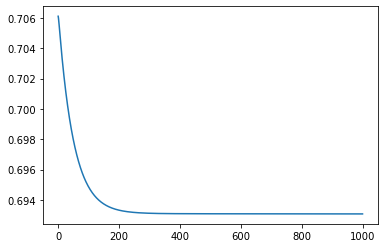

In [1082]:
num_in = X.shape[0]             #input dim
num_hidden = [20,10,5]                #number of hidden units
num_out = y.shape[0]            #output dim
lr = 0.01                       #learning rate
losses = []  
n_iter = 1000

#create neural network instance
if len(num_hidden) == 1:
    model = Net1(num_in,num_hidden,num_out)
elif len(num_hidden) == 2:
    model = Net2(num_in,num_hidden,num_out)
elif len(num_hidden) == 3:
    model = Net3(num_in,num_hidden,num_out)
else:
    print("Error: too many layers")

#define an optimiser (stochastic Gradient Descent)
criterion = nn.BCELoss()                                                  #pick loss function (binary cross entropy)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = 0.5)    #use SCG optimiser

#transpose matrices
X_tensor = torch.from_numpy(X.T).type(torch.float)
y_tensor = torch.from_numpy(y.T).type(torch.float)

for i in range(n_iter):
    optimizer.zero_grad()           # 1) reset grad since pytorch accumulates grad
    y_hat = model(X_tensor)                # 2) forward pass - calling model(X) automatically calls model.forward(X)
    loss = criterion(y_hat, y_tensor)      # 3) keep track of losses
    losses.append(loss)             
    loss.backward()                 # 4) backward pass
    optimizer.step()                # 5) update weights

plt.figure()
plt.plot(losses)

In [1084]:
#predict
X_test_tensor = torch.from_numpy(X_test.T).type(torch.float)
y_hat = model(X_test_tensor)
y_hat = y_hat.detach().numpy()
y_pred = np.array( y_hat>0.5 )
y_pred.reshape(1,-1)

y_test = np.array(y_test)
print(classification_report(y_test, y_pred, zero_division=0))


              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67      6669
         1.0       0.00      0.00      0.00      6683

    accuracy                           0.50     13352
   macro avg       0.25      0.50      0.33     13352
weighted avg       0.25      0.50      0.33     13352



# 10) KNN
- K = 1 (nearest neighbour analysis) works best

In [178]:
df_0 = df_class_diff[df_class_diff["same_cluster"]==0]
df_1 = df_class_diff[df_class_diff["same_cluster"]==1]
if len(df_0) < len(df_1):
    df_class_random = pd.concat([df_0, df_1[:len(df_0)]])
else:
    df_class_random = pd.concat([df_1, df_0[:len(df_1)]])
df_class_random = df_class_random.sample(frac = 1).reset_index(drop = True)

n_train = 12000
#class labels
y = np.array(df_class_random["same_cluster"])
y = y[0:n_train]
y_test = np.array(df_class_random["same_cluster"])
y_test = y_test[n_train:]
y = y.astype(float)
y_test = y_test.astype(float)
print(y.shape)

#attributes
X = np.array(df_class_random[["edge_length_diff", "origin_connections_diff", 
                              "target_connections_diff", "total_connections_diff", 
                              "max_angle_diff", "sum_angle_diff"]][0:n_train])

X_test = np.array(df_class_random[["edge_length_diff", "origin_connections_diff", 
                              "target_connections_diff", "total_connections_diff", 
                              "max_angle_diff", "sum_angle_diff"]][n_train:])

print(X.shape)

(12000,)
(12000, 6)


Text(0.5, 1.0, 'KNN')

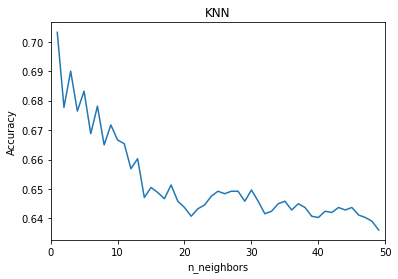

In [180]:
n_neighbors_max = 50
n_neighbors_range = np.arange(1,n_neighbors_max,1)
accuracy_knn = []

for n_neighbors in n_neighbors_range:
    #1) Create KNN Classifier
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)

    #2) Train the model using the training sets
    clf.fit(X, y)

    #3) Predict the response for test dataset
    y_pred = clf.predict(X_test)

    #Evaluate model
    accuracy_knn.append(sklearn.metrics.accuracy_score(y_test, y_pred))

plt.plot(n_neighbors_range,accuracy_knn)
plt.xlabel("n_neighbors")
plt.xlim([0,n_neighbors_max])
plt.ylabel("Accuracy")
plt.title("KNN")

In [181]:
#1) Create KNN Classifier
clf = KNeighborsClassifier(n_neighbors=1)

#2) Train the model using the training sets
clf.fit(X, y)

#3) Predict the response for test dataset
y_pred = clf.predict(X_test)

#Evaluate model
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

         0.0       0.72      0.71      0.71      1220
         1.0       0.69      0.70      0.69      1132

    accuracy                           0.70      2352
   macro avg       0.70      0.70      0.70      2352
weighted avg       0.70      0.70      0.70      2352



## 10b) Normalise features

In [187]:
max_n= int(np.ceil((len(df_class) * (len(df_class)-1)) / 2))
df_class_norm = pd.DataFrame(index = np.arange(max_n), columns = ["edge1", "edge2", "same_cluster",
                                                                  "edge_length_diff", "origin_connections_diff", 
                                                                  "target_connections_diff", "total_connections_diff", 
                                                                  "max_angle_diff", "sum_angle_diff"])

df_class_norm["edge1"] = df_class_diff["edge1"]
df_class_norm["edge2"] = df_class_diff["edge2"]
df_class_norm["same_cluster"] = df_class_diff["same_cluster"]
df_class_norm["edge_length_diff"] = df_class_diff["edge_length_diff"] / df_class_diff["edge_length_diff"].max()
df_class_norm["origin_connections_diff"] = df_class_diff["origin_connections_diff"] / df_class_diff["origin_connections_diff"].max()
df_class_norm["target_connections_diff"] = df_class_diff["target_connections_diff"] / df_class_diff["target_connections_diff"].max()
df_class_norm["total_connections_diff"] = df_class_diff["total_connections_diff"] / df_class_diff["total_connections_diff"].max()
df_class_norm["max_angle_diff"] = df_class_diff["max_angle_diff"] / df_class_diff["max_angle_diff"].max()
df_class_norm["sum_angle_diff"] = df_class_diff["sum_angle_diff"] / df_class_diff["sum_angle_diff"].max()

df_class_norm.tail()

,edge1,edge2,same_cluster,edge_length_diff,origin_connections_diff,target_connections_diff,total_connections_diff,max_angle_diff,sum_angle_diff
17386,Eingang_WayPoint86,WayPoint35_WayPoint17,1,0.00947932,0,0.4,0.25,0.127529,0.363938
17387,Eingang_WayPoint86,Feuerloescher_Seminarraum,1,0.0158899,0.2,0.6,0.5,0.0394208,0.425802
17388,Ambulanz_WayPoint67,WayPoint35_WayPoint17,0,0.385075,0.2,0,0.125,0.0393189,0.0408143
17389,Ambulanz_WayPoint67,Feuerloescher_Seminarraum,0,0.391486,0.4,0.2,0.375,0.206268,0.0210501
17390,WayPoint35_WayPoint17,Feuerloescher_Seminarraum,1,0.00641062,0.2,0.2,0.25,0.166949,0.0618644


In [188]:
df_0 = df_class_norm[df_class_norm["same_cluster"]==0]
df_1 = df_class_norm[df_class_norm["same_cluster"]==1]
if len(df_0) < len(df_1):
    df_class_random = pd.concat([df_0, df_1[:len(df_0)]])
else:
    df_class_random = pd.concat([df_1, df_0[:len(df_1)]])
df_class_random = df_class_random.sample(frac = 1).reset_index(drop = True)

n_train = 12000
#class labels
y = np.array(df_class_random["same_cluster"])
y = y[0:n_train]
y_test = np.array(df_class_random["same_cluster"])
y_test = y_test[n_train:]
y = y.astype(float)
y_test = y_test.astype(float)
print(y.shape)

#attributes
X = np.array(df_class_random[["edge_length_diff", "origin_connections_diff", 
                              "target_connections_diff", "total_connections_diff", 
                              "max_angle_diff", "sum_angle_diff"]][0:n_train])

X_test = np.array(df_class_random[["edge_length_diff", "origin_connections_diff", 
                              "target_connections_diff", "total_connections_diff", 
                              "max_angle_diff", "sum_angle_diff"]][n_train:])

print(X.shape)

(12000,)
(12000, 6)


Text(0.5, 1.0, 'KNN')

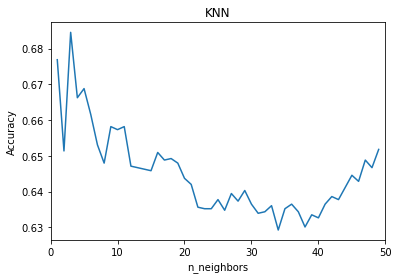

In [193]:
n_neighbors_max = 50
n_neighbors_range = np.arange(1,n_neighbors_max,1)
accuracy_knn = []

for n_neighbors in n_neighbors_range:
    #1) Create KNN Classifier
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)

    #2) Train the model using the training sets
    clf.fit(X, y)

    #3) Predict the response for test dataset
    y_pred = clf.predict(X_test)

    #Evaluate model
    accuracy_knn.append(sklearn.metrics.accuracy_score(y_test, y_pred))

plt.plot(n_neighbors_range,accuracy_knn)
plt.xlabel("n_neighbors")
plt.xlim([0,n_neighbors_max])
plt.ylabel("Accuracy")
plt.title("KNN")

In [196]:
#1) Create KNN Classifier
clf = KNeighborsClassifier(n_neighbors=3)

#2) Train the model using the training sets
clf.fit(X, y)

#3) Predict the response for test dataset
y_pred = clf.predict(X_test)

#Evaluate model
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

         0.0       0.68      0.69      0.68      1169
         1.0       0.69      0.68      0.68      1183

    accuracy                           0.68      2352
   macro avg       0.68      0.68      0.68      2352
weighted avg       0.68      0.68      0.68      2352



## 10c) Use fewer features

In [197]:
max_n= int(np.ceil((len(df_class) * (len(df_class)-1)) / 2))
df_class_subset = pd.DataFrame(index = np.arange(max_n), columns = ["edge1", "edge2", "same_cluster",
                                                                  "edge_length_diff", "origin_connections_diff", 
                                                                  "target_connections_diff", "total_connections_diff", 
                                                                  "max_angle_diff", "sum_angle_diff"])

df_class_subset["edge1"] = df_class_diff["edge1"]
df_class_subset["edge2"] = df_class_diff["edge2"]
df_class_subset["same_cluster"] = df_class_diff["same_cluster"]
df_class_subset["edge_length_diff"] = df_class_diff["edge_length_diff"] 
#df_class_subset["origin_connections_diff"] = df_class_diff["origin_connections_diff"] 
#df_class_subset["target_connections_diff"] = df_class_diff["target_connections_diff"] 
#df_class_subset["total_connections_diff"] = df_class_diff["total_connections_diff"] 
df_class_subset["max_angle_diff"] = df_class_diff["max_angle_diff"] 
df_class_subset["sum_angle_diff"] = df_class_diff["sum_angle_diff"] 

df_class_norm.tail()

,edge1,edge2,same_cluster,edge_length_diff,origin_connections_diff,target_connections_diff,total_connections_diff,max_angle_diff,sum_angle_diff
17386,Eingang_WayPoint86,WayPoint35_WayPoint17,1,0.00947932,0,0.4,0.25,0.127529,0.363938
17387,Eingang_WayPoint86,Feuerloescher_Seminarraum,1,0.0158899,0.2,0.6,0.5,0.0394208,0.425802
17388,Ambulanz_WayPoint67,WayPoint35_WayPoint17,0,0.385075,0.2,0,0.125,0.0393189,0.0408143
17389,Ambulanz_WayPoint67,Feuerloescher_Seminarraum,0,0.391486,0.4,0.2,0.375,0.206268,0.0210501
17390,WayPoint35_WayPoint17,Feuerloescher_Seminarraum,1,0.00641062,0.2,0.2,0.25,0.166949,0.0618644


In [198]:
df_0 = df_class_subset[df_class_subset["same_cluster"]==0]
df_1 = df_class_subset[df_class_subset["same_cluster"]==1]
if len(df_0) < len(df_1):
    df_class_random = pd.concat([df_0, df_1[:len(df_0)]])
else:
    df_class_random = pd.concat([df_1, df_0[:len(df_1)]])
df_class_random = df_class_random.sample(frac = 1).reset_index(drop = True)

n_train = 12000
#class labels
y = np.array(df_class_random["same_cluster"])
y = y[0:n_train]
y_test = np.array(df_class_random["same_cluster"])
y_test = y_test[n_train:]
y = y.astype(float)
y_test = y_test.astype(float)
print(y.shape)

#attributes
"""
X = np.array(df_class_random[["edge_length_diff", "origin_connections_diff", 
                              "target_connections_diff", "total_connections_diff", 
                              "max_angle_diff", "sum_angle_diff"]][0:n_train])

X_test = np.array(df_class_random[["edge_length_diff", "origin_connections_diff", 
                              "target_connections_diff", "total_connections_diff", 
                              "max_angle_diff", "sum_angle_diff"]][n_train:])
"""
X = np.array(df_class_random[["edge_length_diff", 
                              "max_angle_diff", "sum_angle_diff"]][0:n_train])

X_test = np.array(df_class_random[["edge_length_diff", 
                              "max_angle_diff", "sum_angle_diff"]][n_train:])


print(X.shape)

(12000,)
(12000, 3)


Text(0.5, 1.0, 'KNN')

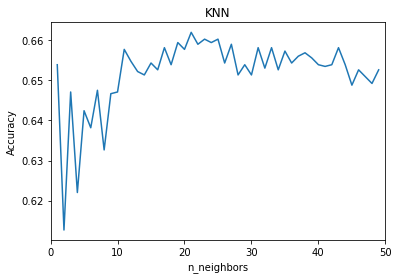

In [201]:
n_neighbors_max = 50
n_neighbors_range = np.arange(1,n_neighbors_max,1)
accuracy_knn = []

for n_neighbors in n_neighbors_range:
    #1) Create KNN Classifier
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)

    #2) Train the model using the training sets
    clf.fit(X, y)

    #3) Predict the response for test dataset
    y_pred = clf.predict(X_test)

    #Evaluate model
    accuracy_knn.append(sklearn.metrics.accuracy_score(y_test, y_pred))

plt.plot(n_neighbors_range,accuracy_knn)
plt.xlabel("n_neighbors")
plt.xlim([0,n_neighbors_max])
plt.ylabel("Accuracy")
plt.title("KNN")

In [200]:
#1) Create KNN Classifier
clf = KNeighborsClassifier(n_neighbors=1)

#2) Train the model using the training sets
clf.fit(X, y)

#3) Predict the response for test dataset
y_pred = clf.predict(X_test)

#Evaluate model
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

         0.0       0.63      0.66      0.65      1130
         1.0       0.67      0.64      0.66      1222

    accuracy                           0.65      2352
   macro avg       0.65      0.65      0.65      2352
weighted avg       0.65      0.65      0.65      2352



## 10d) Effect of increasing samples

1000 datapoints: 8.037228345870972 secs
2000 datapoints: 15.823958396911621 secs
3000 datapoints: 23.267600059509277 secs
4000 datapoints: 31.17196249961853 secs
5000 datapoints: 38.36229753494263 secs
6000 datapoints: 45.055908203125 secs
7000 datapoints: 50.92381262779236 secs
8000 datapoints: 56.73663520812988 secs
9000 datapoints: 61.444010734558105 secs
10000 datapoints: 65.28616762161255 secs
11000 datapoints: 68.73206877708435 secs
12000 datapoints: 71.31381344795227 secs
13000 datapoints: 73.21757817268372 secs
Time taken: 73.21757817268372 secs


Text(0.5, 1.0, 'Comparison of K for KNN')

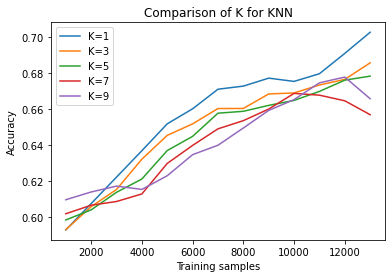

In [203]:
tic = time.time()

#1) Get dataset into correct format
df_0 = df_class_diff[df_class_diff["same_cluster"]==0]
df_1 = df_class_diff[df_class_diff["same_cluster"]==1]
if len(df_0) < len(df_1):
    df_class_random = pd.concat([df_0, df_1[:len(df_0)]])
else:
    df_class_random = pd.concat([df_1, df_0[:len(df_1)]])
df_class_random = df_class_random.sample(frac = 1).reset_index(drop = True)

#2) Train classifier
clf_knn1 = KNeighborsClassifier(n_neighbors=1)
clf_knn3 = KNeighborsClassifier(n_neighbors=3)
clf_knn5 = KNeighborsClassifier(n_neighbors=5)
clf_knn7 = KNeighborsClassifier(n_neighbors=7)
clf_knn9 = KNeighborsClassifier(n_neighbors=9)

#3) select data for train & test
n_train_range = np.arange(1000,14000,1000)
n_iter = 5

accuracy_knn1 = []
accuracy_knn3 = []
accuracy_knn5 = []
accuracy_knn7 = []
accuracy_knn9 = []


for n_train in n_train_range:
    #class labels
    y = np.array(df_class_random["same_cluster"])
    y = y[0:n_train]
    y_test = np.array(df_class_random["same_cluster"])
    y_test = y_test[n_train:]
    y = y.astype(float)
    y_test = y_test.astype(float)

    #attributes
    X = np.array(df_class_random[["edge_length_diff", "origin_connections_diff", 
                                  "target_connections_diff", "total_connections_diff", 
                                  "max_angle_diff", "sum_angle_diff"]][0:n_train])

    X_test = np.array(df_class_random[["edge_length_diff", "origin_connections_diff", 
                                  "target_connections_diff", "total_connections_diff", 
                                  "max_angle_diff", "sum_angle_diff"]][n_train:])
    
    mean_knn1 = 0
    mean_knn3 = 0
    mean_knn5 = 0
    mean_knn7 = 0
    mean_knn9 = 0
    for i in range(n_iter):
        #4) Train Decision Tree Classifer
        clf_knn1 = clf_knn1.fit(X,y)
        clf_knn3 = clf_knn3.fit(X,y)
        clf_knn5 = clf_knn5.fit(X,y)
        clf_knn7 = clf_knn7.fit(X,y)
        clf_knn9 = clf_knn9.fit(X,y)

        #5) Predict the response for test dataset
        y_pred_knn1 = clf_knn1.predict(X_test)
        y_pred_knn3 = clf_knn3.predict(X_test)
        y_pred_knn5 = clf_knn5.predict(X_test)
        y_pred_knn7 = clf_knn7.predict(X_test)
        y_pred_knn9 = clf_knn9.predict(X_test)

        #6) Evaluate model
        mean_knn1 += sklearn.metrics.accuracy_score(y_test,y_pred_knn1)
        mean_knn3 += sklearn.metrics.accuracy_score(y_test,y_pred_knn3)
        mean_knn5 += sklearn.metrics.accuracy_score(y_test,y_pred_knn5)
        mean_knn7 += sklearn.metrics.accuracy_score(y_test,y_pred_knn7)
        mean_knn9 += sklearn.metrics.accuracy_score(y_test,y_pred_knn9)
        
    
    #7) take average
    accuracy_knn1.append(mean_knn1/n_iter)
    accuracy_knn3.append(mean_knn3/n_iter)
    accuracy_knn5.append(mean_knn5/n_iter)
    accuracy_knn7.append(mean_knn7/n_iter)
    accuracy_knn9.append(mean_knn9/n_iter)

    toc = time.time()
    print(n_train, "datapoints:", toc-tic, "secs")

toc = time.time()
print("Time taken:", toc-tic, "secs")
    
#8) Plot
plt.plot(n_train_range, accuracy_knn1)
plt.plot(n_train_range, accuracy_knn3)
plt.plot(n_train_range, accuracy_knn5)
plt.plot(n_train_range, accuracy_knn7)
plt.plot(n_train_range, accuracy_knn9)
plt.xlabel("Training samples")
plt.ylabel("Accuracy")
plt.legend(["K=1","K=3","K=5","K=7","K=9"])
plt.title("Comparison of K for KNN")


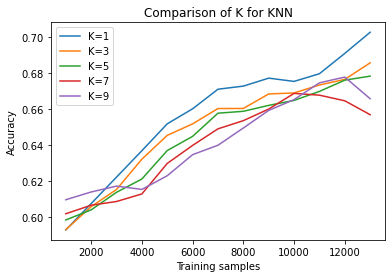

In [204]:
#8) Plot
plt.plot(n_train_range, accuracy_knn1)
plt.plot(n_train_range, accuracy_knn3)
plt.plot(n_train_range, accuracy_knn5)
plt.plot(n_train_range, accuracy_knn7)
plt.plot(n_train_range, accuracy_knn9)
plt.xlabel("Training samples")
plt.ylabel("Accuracy")
plt.legend(["K=1","K=3","K=5","K=7","K=9"])
plt.title("Comparison of K for KNN")
plt.savefig("CompareKforKNN.png", dpi = 1000)

# 11) SVM
- rbf models are the best. Linear/poly are also ok. Sigmoid is bad.
- similar accuracy to logistic regression
- may be a problem with overlapping clusters

In [217]:
df_0 = df_class_diff[df_class_diff["same_cluster"]==0]
df_1 = df_class_diff[df_class_diff["same_cluster"]==1]
if len(df_0) < len(df_1):
    df_class_random = pd.concat([df_0, df_1[:len(df_0)]])
else:
    df_class_random = pd.concat([df_1, df_0[:len(df_1)]])
df_class_random = df_class_random.sample(frac = 1).reset_index(drop = True)

n_train = 10000
#class labels
y = np.array(df_class_random["same_cluster"])
y = y[0:n_train]
y_test = np.array(df_class_random["same_cluster"])
y_test = y_test[n_train:]
y = y.astype(float)
y_test = y_test.astype(float)
print(y.shape)

#attributes
X = np.array(df_class_random[["edge_length_diff", "origin_connections_diff", 
                              "target_connections_diff", "total_connections_diff", 
                              "max_angle_diff", "sum_angle_diff"]][0:n_train])

X_test = np.array(df_class_random[["edge_length_diff", "origin_connections_diff", 
                              "target_connections_diff", "total_connections_diff", 
                              "max_angle_diff", "sum_angle_diff"]][n_train:])

print(X.shape)

(10000,)
(10000, 6)


In [218]:
#Fit
#1) Create classifier
#kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’
kernel = "linear"
clf = svm.SVC(kernel=kernel) # Linear Kernel

#2) Train the model using the training sets
clf.fit(X, y)

#3) Predict the response for test dataset
y_pred = clf.predict(X_test)

#Evaluate model
print(kernel, "kernel")
print(classification_report(y_test, y_pred, zero_division=0))

linear kernel
              precision    recall  f1-score   support

         0.0       0.70      0.51      0.59      2195
         1.0       0.61      0.78      0.68      2157

    accuracy                           0.64      4352
   macro avg       0.66      0.64      0.64      4352
weighted avg       0.66      0.64      0.64      4352



### Try other kernels

In [219]:
#Fit
#1) Create classifier
#kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’
kernel = "poly"
clf = svm.SVC(kernel=kernel) # Linear Kernel

#2) Train the model using the training sets
clf.fit(X, y)

#3) Predict the response for test dataset
y_pred = clf.predict(X_test)

#Evaluate model
print(kernel, "kernel")
print(classification_report(y_test, y_pred, zero_division=0))

poly kernel
              precision    recall  f1-score   support

         0.0       0.77      0.32      0.45      2195
         1.0       0.56      0.90      0.69      2157

    accuracy                           0.61      4352
   macro avg       0.67      0.61      0.57      4352
weighted avg       0.67      0.61      0.57      4352



In [220]:
#Fit
#1) Create classifier
#kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’
kernel = "rbf"
clf = svm.SVC(kernel=kernel) # Linear Kernel

#2) Train the model using the training sets
clf.fit(X, y)

#3) Predict the response for test dataset
y_pred = clf.predict(X_test)

#Evaluate model
print(kernel, "kernel")
print(classification_report(y_test, y_pred, zero_division=0))

rbf kernel
              precision    recall  f1-score   support

         0.0       0.70      0.54      0.61      2195
         1.0       0.62      0.76      0.69      2157

    accuracy                           0.65      4352
   macro avg       0.66      0.65      0.65      4352
weighted avg       0.66      0.65      0.65      4352



In [221]:
#Fit
#1) Create classifier
#kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’
kernel = "sigmoid"
clf = svm.SVC(kernel=kernel) # Linear Kernel

#2) Train the model using the training sets
clf.fit(X, y)

#3) Predict the response for test dataset
y_pred = clf.predict(X_test)

#Evaluate model
print(kernel, "kernel")
print(classification_report(y_test, y_pred, zero_division=0))

sigmoid kernel
              precision    recall  f1-score   support

         0.0       0.57      0.57      0.57      2195
         1.0       0.56      0.57      0.56      2157

    accuracy                           0.57      4352
   macro avg       0.57      0.57      0.57      4352
weighted avg       0.57      0.57      0.57      4352



# 12) Decision Trees
- ID3 uses Information Gain to split (biased for attribute with many outcomes)
- C4.5 uses Gain Ratio (handles bias issue for attributes with many outcomes)
- CART uses Gini Ratio (binary split for each attribute)
- Note: Decision tree has the highest accuracy and f1 ratio (about 70%) and is the only method that improves with dataset size

In [57]:
df_0 = df_class_diff[df_class_diff["same_cluster"]==0]
df_1 = df_class_diff[df_class_diff["same_cluster"]==1]
if len(df_0) < len(df_1):
    df_class_random = pd.concat([df_0, df_1[:len(df_0)]])
else:
    df_class_random = pd.concat([df_1, df_0[:len(df_1)]])
df_class_random = df_class_random.sample(frac = 1).reset_index(drop = True)

#df_class_random = df_class_diff.sample(frac = 1).reset_index(drop = True)

n_train = 14000
#class labels
y = np.array(df_class_random["same_cluster"])
y = y[0:n_train]
y_test = np.array(df_class_random["same_cluster"])
y_test = y_test[n_train:]
y = y.astype(float)
y_test = y_test.astype(float)
print(y.shape)

#attributes
X = np.array(df_class_random[["edge_length_diff", "origin_connections_diff", 
                              "target_connections_diff", "total_connections_diff", 
                              "max_angle_diff", "sum_angle_diff"]][0:n_train])

X_test = np.array(df_class_random[["edge_length_diff", "origin_connections_diff", 
                              "target_connections_diff", "total_connections_diff", 
                              "max_angle_diff", "sum_angle_diff"]][n_train:])

print(X.shape)

(14000,)
(14000, 6)


In [78]:
#Fit
#1) Create Decision Tree classifer object
#criterion{“gini”, “entropy”}, default=”gini”. "entropy" uses information gain
#splitter{“best”, “random”}, default=”best”. "random" uses best random split
#max_depth - too high results in overfitting. Too low results in underfit
clf = DecisionTreeClassifier(criterion = "gini", max_depth = None)

#2) Train Decision Tree Classifer
clf = clf.fit(X,y)

#3) Predict the response for test dataset
y_pred = clf.predict(X_test)

#Evaluate model
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

         0.0       0.67      0.69      0.68       165
         1.0       0.72      0.70      0.71       187

    accuracy                           0.69       352
   macro avg       0.69      0.69      0.69       352
weighted avg       0.69      0.69      0.69       352



In [81]:
sklearn.metrics.accuracy_score(y_test, y_pred)

0.6931818181818182

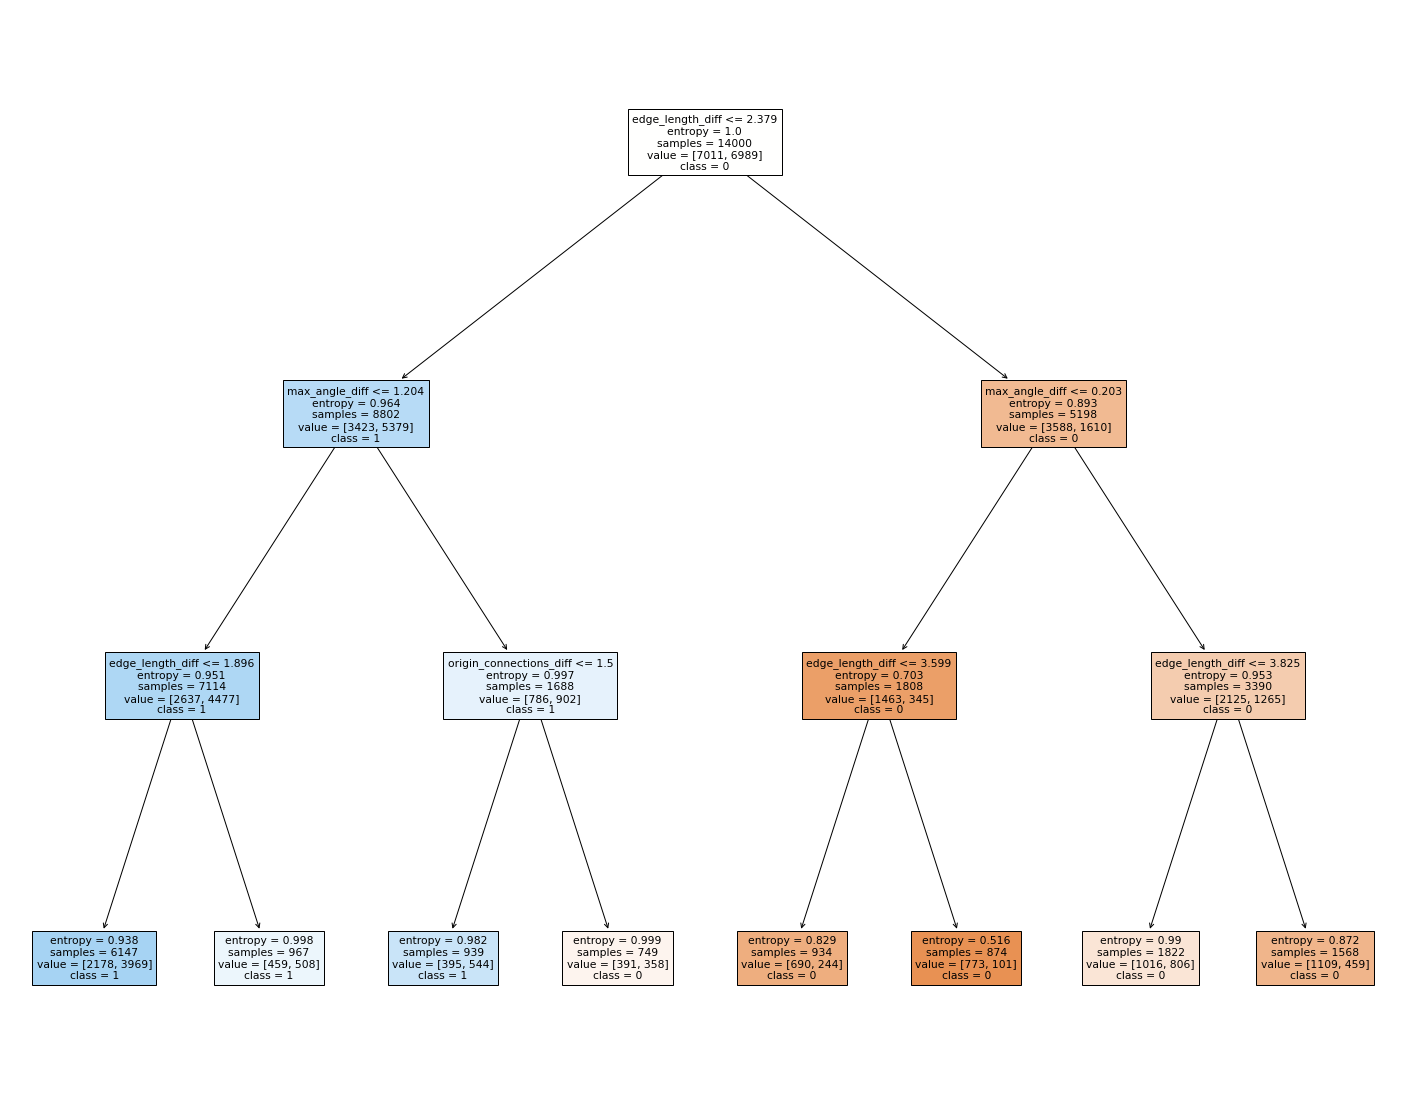

In [66]:
#METHOD 1 - TEXT (use for large max_depth. However, not straightforward to understand)
#text = sklearn.tree.export_text(clf)
#print(text)

#METHOD 2 - GRAPH (use for small max_depth. However, takes too long to plot for max_depth > 5)

feature_cols = ["edge_length_diff", "origin_connections_diff", 
                              "target_connections_diff", "total_connections_diff", 
                              "max_angle_diff", "sum_angle_diff"]

fig = plt.figure(figsize=(25,20))
_ = sklearn.tree.plot_tree(clf, 
                    feature_names = feature_cols,
                    class_names=['0','1'],
                    filled=True)
fig.savefig("tree.png")

In [27]:
#cross validation
cv = 100
y = list(df_class_random["same_cluster"])
X = np.array(df_class_random[["edge_length_diff", "origin_connections_diff", 
                              "target_connections_diff", "total_connections_diff", 
                              "max_angle_diff", "sum_angle_diff"]])
clf = DecisionTreeClassifier(criterion = "gini")
cv_results = cross_validate(clf, X, y, cv=cv)
print("Mean:", cv_results["test_score"].mean())
print("Std:", cv_results["test_score"].std())

Mean: 0.6835324397824397
Std: 0.04087048408617855


## 12b) Effect of max depth (decision tree)
- 5 to 10 branches is best
- However no significant difference and the scores are very variable

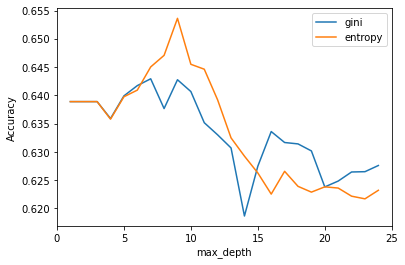

In [96]:
tic = time.time()

#1) Get dataset into correct format
df_0 = df_class_diff[df_class_diff["same_cluster"]==0]
df_1 = df_class_diff[df_class_diff["same_cluster"]==1]
if len(df_0) < len(df_1):
    df_class_random = pd.concat([df_0, df_1[:len(df_0)]])
else:
    df_class_random = pd.concat([df_1, df_0[:len(df_1)]])
df_class_random = df_class_random.sample(frac = 1).reset_index(drop = True)


#3) select data for train & test
n_train = 5000

y = np.array(df_class_random["same_cluster"])
y = y[0:n_train]
y_test = np.array(df_class_random["same_cluster"])
y_test = y_test[n_train:]
y = y.astype(float)
y_test = y_test.astype(float)

#attributes
X = np.array(df_class_random[["edge_length_diff", "origin_connections_diff", 
                              "target_connections_diff", "total_connections_diff", 
                              "max_angle_diff", "sum_angle_diff"]][0:n_train])

X_test = np.array(df_class_random[["edge_length_diff", "origin_connections_diff", 
                              "target_connections_diff", "total_connections_diff", 
                              "max_angle_diff", "sum_angle_diff"]][n_train:])
n_depth_max = 25
n_depth_range = np.arange(1,n_depth_max,1)
accuracy_gini = []
accuracy_entropy = []
n_iter = 100

for n_depth in n_depth_range:
    
    #2) Train classifier
    clf_gini = DecisionTreeClassifier(criterion = "gini", max_depth = n_depth)
    clf_entropy = DecisionTreeClassifier(criterion = "entropy", max_depth = n_depth)

    mean_gini = 0
    mean_entropy = 0
    for i in range(n_iter):
        #4) Train Decision Tree Classifer
        clf_gini = clf_gini.fit(X,y)
        clf_entropy = clf_entropy.fit(X,y)

        #5) Predict the response for test dataset
        y_pred_gini = clf_gini.predict(X_test)
        y_pred_entropy = clf_entropy.predict(X_test)

        #6) Evaluate model
        mean_gini += sklearn.metrics.accuracy_score(y_test, y_pred_gini)
        mean_entropy += sklearn.metrics.accuracy_score(y_test, y_pred_entropy)
        
    #7) take average
    accuracy_gini.append(mean_gini/n_iter)
    accuracy_entropy.append(mean_entropy/n_iter)

toc = time.time()
print("Time taken:", toc-tic, "secs")
#8) Plot
plt.plot(n_depth_range, accuracy_gini)
plt.plot(n_depth_range, accuracy_entropy)
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.xlim([0,n_depth_max])
plt.legend(["gini", "entropy"])


# 13) Random Forest
- also calculates relative feature importance
- metrics are gini importance & MDI (mean decrease in impurity)- both metrics are similar in performance
- random forests prevent overfitting due to random subsets, HWVR are slower & less easy to interpret

In [229]:
df_0 = df_class_diff[df_class_diff["same_cluster"]==0]
df_1 = df_class_diff[df_class_diff["same_cluster"]==1]
if len(df_0) < len(df_1):
    df_class_random = pd.concat([df_0, df_1[:len(df_0)]])
else:
    df_class_random = pd.concat([df_1, df_0[:len(df_1)]])
df_class_random = df_class_random.sample(frac = 1).reset_index(drop = True)

#df_class_random = df_class_diff.sample(frac = 1).reset_index(drop = True)

n_train = 12000
#class labels
y = np.array(df_class_random["same_cluster"])
y = y[0:n_train]
y_test = np.array(df_class_random["same_cluster"])
y_test = y_test[n_train:]
y = y.astype(float)
y_test = y_test.astype(float)
print(y.shape)

#attributes
X = np.array(df_class_random[["edge_length_diff", "origin_connections_diff", 
                              "target_connections_diff", "total_connections_diff", 
                              "max_angle_diff", "sum_angle_diff"]][0:n_train])

X_test = np.array(df_class_random[["edge_length_diff", "origin_connections_diff", 
                              "target_connections_diff", "total_connections_diff", 
                              "max_angle_diff", "sum_angle_diff"]][n_train:])

print(X.shape)

(12000,)
(12000, 6)


In [230]:
#1) Create Classifier
#criterion{“gini”, “entropy”}, default=”gini”. The function to measure the quality of a split.
#max_depthint, default=None. The maximum depth of the tree. 

clf=RandomForestClassifier(n_estimators=100)

#2) Train 
clf.fit(X,y)

#3) Predict
y_pred=clf.predict(X_test)

#Evaluate model
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

         0.0       0.73      0.73      0.73      1140
         1.0       0.75      0.74      0.74      1212

    accuracy                           0.74      2352
   macro avg       0.74      0.74      0.74      2352
weighted avg       0.74      0.74      0.74      2352



## 13b) Cross validation of both metrics (RF)

In [231]:
#cross validation - gini
cv = 10
y = list(df_class_random["same_cluster"])
X = np.array(df_class_random[["edge_length_diff", "origin_connections_diff", 
                              "target_connections_diff", "total_connections_diff", 
                              "max_angle_diff", "sum_angle_diff"]])
clf=RandomForestClassifier(criterion = "gini", n_estimators=100)
cv_results = cross_validate(clf, X, y, cv=cv)
print("Mean:", cv_results["test_score"].mean())
print("Std:", cv_results["test_score"].std())

Mean: 0.7403843428804364
Std: 0.011750347930191925


In [232]:
#cross validation - entropy
cv = 10
y = list(df_class_random["same_cluster"])
X = np.array(df_class_random[["edge_length_diff", "origin_connections_diff", 
                              "target_connections_diff", "total_connections_diff", 
                              "max_angle_diff", "sum_angle_diff"]])
clf=RandomForestClassifier(criterion = "entropy", n_estimators=100)
cv_results = cross_validate(clf, X, y, cv=cv)
print("Mean:", cv_results["test_score"].mean())
print("Std:", cv_results["test_score"].std())

Mean: 0.7428238040239535
Std: 0.012196852856058133


## 13c) Feature importance (RF)

In [210]:
#1) Create Classifier
#criterion{“gini”, “entropy”}, default=”gini”. The function to measure the quality of a split.
#max_depthint, default=None. The maximum depth of the tree. 

clf=RandomForestClassifier(n_estimators=100)

#2) Train 
clf.fit(X,y)

#3) Show importance
feature_names = ["edge_length_diff", "origin_connections_diff", 
                              "target_connections_diff", "total_connections_diff", 
                              "max_angle_diff", "sum_angle_diff"]
importance = pd.Series(clf.feature_importances_,index=feature_names).sort_values(ascending=False)
print(importance)

edge_length_diff           0.356779
max_angle_diff             0.257319
sum_angle_diff             0.246789
total_connections_diff     0.055253
origin_connections_diff    0.045022
target_connections_diff    0.038838
dtype: float64


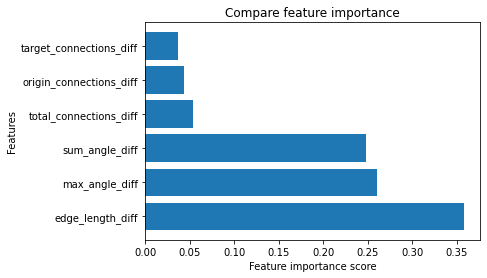

In [155]:
y_pos = [i for i in range(len(importance.index))]

plt.barh(y_pos, importance);
plt.xlabel("Feature importance score")
plt.ylabel("Features")
plt.title("Compare feature importance")
plt.yticks(y_pos, importance.index);
plt.savefig("FeatureImportance.png", bbox_inches="tight", dpi = 1000)

# 14) Compare classification methods
- random forest is best and gets better with more training data
- decision tree is second best and also improves with training data
- SVM & Logistic Regression do not improve with more training data & have worst performance

1000 datapoints: 4.253305196762085 secs
2000 datapoints: 9.750775814056396 secs
3000 datapoints: 16.825416326522827 secs
4000 datapoints: 27.03151845932007 secs
5000 datapoints: 39.03544354438782 secs
6000 datapoints: 53.423298358917236 secs
7000 datapoints: 70.37457418441772 secs
8000 datapoints: 90.18048167228699 secs
9000 datapoints: 112.06730127334595 secs
10000 datapoints: 136.41587257385254 secs
11000 datapoints: 163.6325135231018 secs
12000 datapoints: 193.69430303573608 secs
13000 datapoints: 226.24135637283325 secs
Time taken: 226.24135637283325 secs


Text(0.5, 1.0, 'Comparison of classification methods')

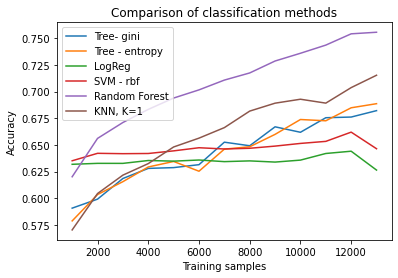

In [202]:
tic = time.time()

#1) Get dataset into correct format
df_0 = df_class_diff[df_class_diff["same_cluster"]==0]
df_1 = df_class_diff[df_class_diff["same_cluster"]==1]
if len(df_0) < len(df_1):
    df_class_random = pd.concat([df_0, df_1[:len(df_0)]])
else:
    df_class_random = pd.concat([df_1, df_0[:len(df_1)]])
df_class_random = df_class_random.sample(frac = 1).reset_index(drop = True)

#2) Train classifier
clf_gini = DecisionTreeClassifier(criterion = "gini", max_depth = None)
clf_entropy = DecisionTreeClassifier(criterion = "entropy", max_depth = None)
clf_lr = LogisticRegression(random_state=0)
clf_svm = svm.SVC(kernel='rbf') 
clf_rf = RandomForestClassifier(n_estimators=100)
clf_knn = KNeighborsClassifier(n_neighbors=1)

#3) select data for train & test
n_train_range = np.arange(1000,14000,1000)
n_iter = 5
accuracy_gini = []
accuracy_entropy = []
accuracy_lr = []
accuracy_svm = []
accuracy_rf = []
accuracy_knn = []


for n_train in n_train_range:
    #class labels
    y = np.array(df_class_random["same_cluster"])
    y = y[0:n_train]
    y_test = np.array(df_class_random["same_cluster"])
    y_test = y_test[n_train:]
    y = y.astype(float)
    y_test = y_test.astype(float)

    #attributes
    X = np.array(df_class_random[["edge_length_diff", "origin_connections_diff", 
                                  "target_connections_diff", "total_connections_diff", 
                                  "max_angle_diff", "sum_angle_diff"]][0:n_train])

    X_test = np.array(df_class_random[["edge_length_diff", "origin_connections_diff", 
                                  "target_connections_diff", "total_connections_diff", 
                                  "max_angle_diff", "sum_angle_diff"]][n_train:])
    
    mean_gini = 0
    mean_entropy = 0
    mean_lr = 0
    mean_svm = 0
    mean_rf = 0
    mean_knn = 0
    for i in range(n_iter):
        #4) Train Decision Tree Classifer
        clf_gini = clf_gini.fit(X,y)
        clf_entropy = clf_entropy.fit(X,y)
        clf_lr = clf_lr.fit(X,y)
        clf_svm = clf_svm.fit(X,y)
        clf_rf = clf_rf.fit(X,y)
        clf_knn = clf_knn.fit(X,y)

        #5) Predict the response for test dataset
        y_pred_gini = clf_gini.predict(X_test)
        y_pred_entropy = clf_entropy.predict(X_test)
        y_pred_lr = clf_lr.predict(X_test)
        y_pred_svm = clf_svm.predict(X_test)
        y_pred_rf = clf_rf.predict(X_test)
        y_pred_knn = clf_knn.predict(X_test)

        #6) Evaluate model
        mean_gini += sklearn.metrics.accuracy_score(y_test, y_pred_gini)
        mean_entropy += sklearn.metrics.accuracy_score(y_test, y_pred_entropy)
        mean_lr += sklearn.metrics.accuracy_score(y_test, y_pred_lr)
        mean_svm += sklearn.metrics.accuracy_score(y_test, y_pred_svm)
        mean_rf += sklearn.metrics.accuracy_score(y_test,y_pred_rf)
        mean_knn += sklearn.metrics.accuracy_score(y_test,y_pred_knn)
    
    #7) take average
    accuracy_gini.append(mean_gini/n_iter)
    accuracy_entropy.append(mean_entropy/n_iter)
    accuracy_lr.append(mean_lr/n_iter)
    accuracy_svm.append(mean_svm/n_iter)
    accuracy_rf.append(mean_rf/n_iter)
    accuracy_knn.append(mean_knn/n_iter)

    toc = time.time()
    print(n_train, "datapoints:", toc-tic, "secs")

toc = time.time()
print("Time taken:", toc-tic, "secs")
    
#8) Plot
plt.plot(n_train_range, accuracy_gini)
plt.plot(n_train_range, accuracy_entropy)
plt.plot(n_train_range, accuracy_lr)
plt.plot(n_train_range, accuracy_svm)
plt.plot(n_train_range, accuracy_rf)
plt.plot(n_train_range, accuracy_knn)
plt.xlabel("Training samples")
plt.ylabel("Accuracy")
plt.legend(["Tree- gini", "Tree - entropy", "LogReg", "SVM - rbf", "Random Forest", "KNN, K=1"])
plt.title("Comparison of classification methods")


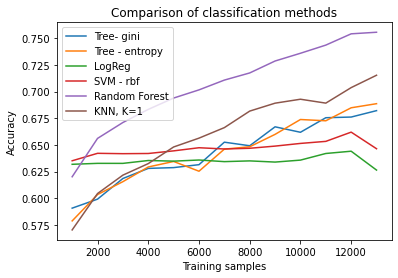

In [209]:
#8) Plot
plt.plot(n_train_range, accuracy_gini)
plt.plot(n_train_range, accuracy_entropy)
plt.plot(n_train_range, accuracy_lr)
plt.plot(n_train_range, accuracy_svm)
plt.plot(n_train_range, accuracy_rf)
plt.plot(n_train_range, accuracy_knn)
plt.xlabel("Training samples")
plt.ylabel("Accuracy")
plt.legend(["Tree- gini", "Tree - entropy", "LogReg", "SVM - rbf", "Random Forest", "KNN, K=1"])
plt.title("Comparison of classification methods")

plt.savefig("CompareClassification.png",dpi = 1000)

In [206]:
accuracy_rf[-1]

0.7554733727810651